In [12]:
import yaml
import os 

import pandas as pd
import numpy as np


Формирование файлов, которые отсутствуют

Данные для обучения

In [13]:
analysis_direction = os.getcwd()
name_exp = 'PerceptMapper\data'
os.chdir('../' + name_exp)
exp = os.getcwd()
os.chdir(analysis_direction)

CLFTrain = {'X': [], 'Y': [], 'Region': []}
Predict = {'X': [], 'Y': [], 'Picture': [], 'Participant': []}
for files in os.walk(exp):
    if files[0] == exp + '\TrainTest':
        mapper = CLFTrain
    else:
        mapper = Predict

    for name in files[2]:
        if 'imPixel.yml' in name:
            with open(files[0] + '/' + name, "r") as stream:   
                flag_val = False
                keys = ['pos', 'size', 'sensation0_Rpalmar']
                for line in stream:

                    if flag_val == False:
                        line = line.split('\n')[0].split(':')[0]
                        if line == keys[0]:
                            key = keys[0]
                            for i in range(2):
                                line = ''.join(stream.readline().split('\n')[0].split(':')[0].split(' '))
                        
                        elif line == keys[1]:
                            key = keys[1]
                            for i in range(2):
                                line = ''.join(stream.readline().split('\n')[0].split(':')[0].split(' '))
                        
                        elif line == keys[2]:
                            flag_val = True
                            line = stream.readline()

                    if flag_val: # У Кати дополнительная проверка, пушто size не на 3-й строчке, а в конце, поэтому доп проверка
                        for key in keys:
                            if line.split('\n')[0].split(':')[0] == key: 
                                flag_val = False
                        
                    if flag_val:   
                        line = ''.join(line.split(' '))
                        mapper['X'].append(float(line))
                        line = ''.join(stream.readline().split('\n')[0].split(':')[0].split(' '))
                        mapper['Y'].append(float(line))
                        if files[0] != exp + '\TrainTest':
                            reg_pic = 'Picture'
                            mapper['Participant'].append(files[0].split(exp)[-1][1:])
                        else:
                            reg_pic = 'Region'

                        region = int(name.split('_R')[1].split('_')[0])
                        if region < 10:
                            region = str(f'0{region}')
                        else:
                            region = str(region)
                        mapper[reg_pic].append(region)

                stream.close()

data_raw = pd.DataFrame.from_dict(CLFTrain)
data_raw['X'] = (data_raw['X'] - data_raw['X'].min()) / (data_raw['X'].max() - data_raw['X'].min())
data_raw['Y'] = (data_raw['Y'] - data_raw['Y'].min()) / (data_raw['Y'].max() - data_raw['Y'].min())
data_raw.to_csv('Training/Classifier_training.csv', index = False)

data_raw = pd.DataFrame.from_dict(Predict)
data_raw['X'] = (data_raw['X'] - data_raw['X'].min()) / (data_raw['X'].max() - data_raw['X'].min())
data_raw['Y'] = (data_raw['Y'] - data_raw['Y'].min()) / (data_raw['Y'].max() - data_raw['Y'].min())
data_raw.to_csv('Data prepared/Pixels only.csv', index = False)

# data_raw

Классификация зон чувствительности

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_decision_regions

import matplotlib.pyplot as plt

In [15]:
train = pd.read_csv('Training/Classifier_training.csv')
predict = pd.read_csv('Data prepared/Pixels only.csv')

train_x = train.drop(['Region'], axis=1)
train_y = pd.get_dummies(train['Region'])
keys_regions = list(train_y.keys())

pred = predict.drop(['Picture', 'Participant'], axis=1)

In [16]:
to_concat = predict.drop(['X', 'Y'], axis=1).to_dict('list')

classifier = KNeighborsClassifier(n_neighbors= 1, n_jobs= -1)
clf = classifier.fit(train_x, train_y)
print(f'{classifier}\n\tTrain: {mse(train_y, clf.predict(train_x))}')


for name in keys_regions:
    to_concat[name] = []
for arr in clf.predict(pred).tolist():
    for name, var in zip(keys_regions, arr):
        if var == 0:
            var = None
        to_concat[name].append(var)
    
to_concat = pd.DataFrame(to_concat)
to_concat # Предсказание зоны для каждой точки

KNeighborsClassifier(n_jobs=-1, n_neighbors=1)
	Train: 0.0017794610406715531


,Picture,Participant,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,Antipushina,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,NaN
1,0,Antipushina,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,NaN
2,0,Antipushina,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,NaN
3,0,Antipushina,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,NaN
4,0,Antipushina,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41768,51,Suin,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,NaN
41769,51,Suin,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,NaN
41770,51,Suin,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,NaN
41771,51,Suin,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,NaN


In [17]:
to_concat_dict = to_concat.groupby(['Participant', 'Picture']).count()
type(to_concat_dict)
to_concat_dict.to_csv('Data prepared/Predicted_2.csv')
display(to_concat_dict)
to_concat_dict = pd.read_csv('Data prepared/Predicted_2.csv').to_dict('list')

threshold = 10

cols_rename = {}
for key in list(to_concat_dict.keys())[2:]:
    cols_rename[key] = 'PredR ' + str(int(key)+1)
    temp = []
    for val in to_concat_dict[key]:
        if val >= threshold:
            val = 1
        else: val = 0
        temp.append(val)
    to_concat_dict[key] = temp
to_concat_dict = pd.DataFrame(to_concat_dict).rename(columns = cols_rename)
to_concat_dict.to_csv('Data prepared/Pred.csv', index= False)
display(to_concat_dict) # Для каждой картинки (уже будет много меньше строк)


0   1   2  3   4  5  6  7   8    9   10  11  12  13  14  \
Participant Picture                                                            
Antipushina 0        0   0   0  0   0  0  0  0   0   39  423   0   0   0   0   
            6        0   0  27  0   0  0  0  0   0  216   32   0   0   0   0   
            7        0   0   0  0   0  0  0  0   1  174    0   0   0   0   0   
            8        0   0   0  0   0  0  0  0   0    0    0   0   0   0   0   
            9        0   0   0  0   0  0  0  0   0  286    0   0   0   0   0   
...                 ..  ..  .. ..  .. .. .. ..  ..  ...  ...  ..  ..  ..  ..   
Suin        47       0  15  50  7  20  0  0  0  41   78   80  19  20   0  13   
            48       0   0   0  0   0  0  0  0   1    0    0   0   0   0   0   
            49       0   0   7  2   0  0  0  0   2   73   47   3   0   0   0   
            50       0   0   0  0   0  0  0  0   0    0    0   0   0   0   0   
            51       0   0   0  0   0  0  0  0   0    0    0   0   0   0   0   

                      15  16  
Participant Picture           
Antipushina 0        127   0  
            6         70   0  
            7         79   0  
            8        116   0  
            9        120   0  
...                  ...  ..  
Suin        47       146   0  
            48        19   0  
            49         0   0  
            50        34   0  
            51        18   0  

[213 rows x 17 columns]

,Participant,Picture,PredR 1,PredR 2,PredR 3,PredR 4,PredR 5,PredR 6,PredR 7,PredR 8,PredR 9,PredR 10,PredR 11,PredR 12,PredR 13,PredR 14,PredR 15,PredR 16,PredR 17
0,Antipushina,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0
1,Antipushina,6,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0
2,Antipushina,7,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,Antipushina,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Antipushina,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,Suin,47,0,1,1,0,1,0,0,0,1,1,1,1,1,0,1,1,0
209,Suin,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
210,Suin,49,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
211,Suin,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


-------

Проверка на классификатора на тесте (через конфьюжн матрицу)

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

In [19]:
accur_test = pd.read_csv('Training/Test_of_clf.csv')
if len(list(accur_test.keys())) == 1:
    accur_test = pd.read_csv('Training/Test_of_clf.csv', sep = ';')
accur_test = accur_test.drop(columns = 'Part of a body').rename(columns= {'Zones': 'PicList'})

accur_test.loc[accur_test["Participant"] == 'Alexey Sokolov', "Participant"] = 'Sokolov'
accur_test.loc[accur_test["Participant"] == 'Semen Mukhamadiev', "Participant"] = 'Mukhamadiev'
accur_test_dict = accur_test.to_dict('list')

temp = []
for i in range(17):
    temp.append(0)
    accur_test_dict[f'true_PredR {str(i+1)}'] = []

for arr in accur_test_dict['PicList']:
    arr = arr.split(',')
    
    if arr[0] != '-':
        for val in range(len(arr)):
            arr[val] = int(arr[val])
            temp[arr[val]-1] = 1
    for i in range(17):
        accur_test_dict[f'true_PredR {str(i+1)}'].append(temp[i])
        temp[i] = 0

pd.DataFrame(accur_test_dict).to_csv('Training/Test_of_clf_modif.csv', index=False)


In [20]:
test = pd.merge(pd.DataFrame(accur_test_dict), to_concat_dict, on=['Participant','Picture'])
to_true=[]
to_pred=[]
att = {}
for i in range(17):
    to_true.append(f'true_PredR {str(i+1)}')
    to_pred.append(f'PredR {str(i+1)}')
    att[f'true_PredR {str(i+1)}'] = f'PredR {str(i+1)}'

for i in ['Participant', 'Picture', 'PicList']:
    to_true.append(i)
    to_pred.append(i)

test_true = test.drop(columns= to_pred).rename(columns=att)
test_pred = test.drop(columns= to_true)

# for name in list(test_pred.keys()):
#     test_true.loc[test_true[name] == 0, name] = False
#     test_true.loc[test_true[name] == 1, name] = True
#     test_pred.loc[test_pred[name] == 0, name] = False
#     test_pred.loc[test_pred[name] == 1, name] = True

print('test_true')
display(test_true)
print('test_pred')
display(test_pred)

labels = []
for i in range(17):
    labels.append(str(i+1))
confus_matr = multilabel_confusion_matrix(test_true.to_numpy(), test_pred.to_numpy())

for i, arr in enumerate(confus_matr):
    #print(f'For region {labels[i]}:\n {arr}')
    acc = 1 - (arr[0][1] + arr[1][0])/(arr[0][0] + arr[1][1] + arr[0][1] + arr[1][0])
    print(f'For region {labels[i]}:\t Precission: {arr[0][0]/(arr[0][0] + arr[0][1]):.3f}\t Recall: {arr[0][0]/(arr[0][0] + arr[1][0]):.3f}\t Accuracy: {acc:.3f}')

print(f'\n{classifier}\n\tMSE Test: {mse(test_true, test_pred)}')


test_true


,PredR 1,PredR 2,PredR 3,PredR 4,PredR 5,PredR 6,PredR 7,PredR 8,PredR 9,PredR 10,PredR 11,PredR 12,PredR 13,PredR 14,PredR 15,PredR 16,PredR 17
0,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,1,0
1,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,1,0
3,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0
57,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0
58,0,0,1,1,1,1,0,0,0,1,1,1,0,0,0,1,0
59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


test_pred


,PredR 1,PredR 2,PredR 3,PredR 4,PredR 5,PredR 6,PredR 7,PredR 8,PredR 9,PredR 10,PredR 11,PredR 12,PredR 13,PredR 14,PredR 15,PredR 16,PredR 17
0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0
1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0
3,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
57,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
58,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0
59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


For region 1:	 Precission: 1.000	 Recall: 0.885	 Accuracy: 0.885
For region 2:	 Precission: 0.978	 Recall: 1.000	 Accuracy: 0.984
For region 3:	 Precission: 0.172	 Recall: 1.000	 Accuracy: 0.607
For region 4:	 Precission: 0.750	 Recall: 0.250	 Accuracy: 0.672
For region 5:	 Precission: 0.962	 Recall: 0.510	 Accuracy: 0.590
For region 6:	 Precission: 1.000	 Recall: 0.574	 Accuracy: 0.574
For region 7:	 Precission: 1.000	 Recall: 1.000	 Accuracy: 1.000
For region 8:	 Precission: 1.000	 Recall: 1.000	 Accuracy: 1.000
For region 9:	 Precission: 1.000	 Recall: 1.000	 Accuracy: 1.000
For region 10:	 Precission: 0.714	 Recall: 0.862	 Accuracy: 0.770
For region 11:	 Precission: 0.800	 Recall: 0.333	 Accuracy: 0.852
For region 12:	 Precission: 1.000	 Recall: 0.393	 Accuracy: 0.393
For region 13:	 Precission: 1.000	 Recall: 0.984	 Accuracy: 0.984
For region 14:	 Precission: 1.000	 Recall: 1.000	 Accuracy: 1.000
For region 15:	 Precission: 1.000	 Recall: 1.000	 Accuracy: 1.000
For region 16:	 Pre

--------------

Объединяем с остальными данными (тут есть ещё и корректировка .csv)

In [21]:
name_exp = 'Experiment_1\data'
os.chdir('../' + name_exp)
exp = os.getcwd()
os.chdir(analysis_direction)

Experimental_data_1 = pd.DataFrame()
for files in os.walk(exp):
    for name in files[2]:
        if '_log' not in name:
            exp_n = files[0].split(exp)[-1][1:]
            pandas_temp = pd.read_csv(f'{files[0]}/{name}')
            if len(list(pandas_temp.keys())) == 1:
                pandas_temp = pd.read_csv(f'{files[0]}/{name}', sep=';').drop(['Amp'], axis=1)
            else:
                pandas_temp = pandas_temp.drop(['Amp'], axis=1)
            # pandas_temp = pandas_temp.dropna().rename(columns = {'Number': 'Participant'})
            pandas_temp = pandas_temp.rename(columns = {'Number': 'Participant'})
            pandas_temp.loc[pandas_temp["Participant"] > 0, "Participant"] = exp_n
            pandas_temp = pandas_temp.dropna()
            pandas_temp['Picture'] = np.int_(pandas_temp['Picture'])
            #pd_Kny = pandas_temp[pandas_temp['Participant'] == 'Knyshenko']
            Experimental_data_1 = pd.concat([Experimental_data_1, pandas_temp], axis=0)

print('\nfrom MotionStim_ipynb')
display(Experimental_data_1)



from MotionStim_ipynb


,Participant,Date,Time,Pulse,Frequency,Duration,Value,Picture
0,Knyshenko,Mar-09,14_35_11,100,8,250,Passed,0
1,Knyshenko,Mar-09,14_36_06,200,50,500,Passed,1
2,Knyshenko,Mar-09,14_37_42,100,50,50,Passed,2
3,Knyshenko,Mar-09,14_38_15,50,95,50,Passed,3
4,Knyshenko,Mar-09,14_38_40,200,15,250,Passed,4
...,...,...,...,...,...,...,...,...
51,Suin,Mar-07,12_48_33,400,50,500,Passed,47
52,Suin,Mar-07,12_49_40,100,50,50,Passed,48
53,Suin,Mar-07,12_49_55,400,30,250,Passed,49
54,Suin,Mar-07,12_50_43,100,15,500,Passed,50


In [22]:
analysis_direction = os.getcwd()
name_exp = 'PerceptMapper\data\TrainTest'
name_exp = 'PerceptMapper\data'
os.chdir('../' + name_exp)
exp = os.getcwd()
os.chdir(analysis_direction)

Experimental_data_1_sliders = pd.DataFrame()
for files in os.walk(exp):
    if files[0] != exp + '\TrainTest':
        for name in files[2]:
            temp_dict = {'Participant': [], 'Picture': []}
            if '.csv' in name:
                print(name)
                
                exp_n = files[0].split(exp)[-1][1:]
                pandas_temp = pd.read_csv(f'{files[0]}/{name}', sep=';')
                if len(list(pandas_temp.keys())) == 1:
                    pandas_temp = pd.read_csv(f'{files[0]}/{name}', sep=',')
                    
                #display(pandas_temp)
                for i in range(pandas_temp.to_numpy().shape[0]):
                    temp_dict['Participant'].append(exp_n)
                #print(pandas_temp.keys())
                temp_dict['Picture'] = pandas_temp.to_dict('list')['Picture']
                
                for key in ['maintactileSlider', 'motorSlider', 'naturalSlider', 'painSlider', 'phantomSlider', 'tempSlider']:
                    pandas_temp[key] = pandas_temp[key].to_numpy()


                pandas_temp = pd.merge(pandas_temp, pd.DataFrame.from_dict(temp_dict), on=['Picture'])
                #pd_Kny = pandas_temp[pandas_temp['Participant'] == 'Knyshenko']
                Experimental_data_1_sliders = pd.concat([Experimental_data_1_sliders, pandas_temp], axis=0)
                
print('\nfrom Sliders')

display(Experimental_data_1_sliders)

Katherine_allData.csv
Misha_allData.csv
Vyacheslav Kudryavsky.csv
Semen Mukhamadiev_allData.csv
Dmitrii_Perevozniuk_allData.csv
Alexey Sokolov.csv
Sasha_allData.csv

from Sliders


C:\Users\asus\AppData\Local\Temp\ipykernel_19972\2122859654.py:33: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  Experimental_data_1_sliders = pd.concat([Experimental_data_1_sliders, pandas_temp], axis=0)
c:\Users\asus\anaconda3\lib\site-packages\IPython\lib\pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
c:\Users\asus\anaconda3\lib\site-packages\IPython\core\formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,Picture,Time,Muscle contraction,Electric Current,Twitching,Itching,maintactileSlider,motorSlider,naturalSlider,Numbness,...,Puncture,Hit,tempSlider,Tickling,Tingling,Touch,Intention to Make Movement,Vibration,Participant,Was Felt
0,0,17:27:59,0.0,0.0,0.0,0.0,5,"1,9","-2,9",0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,Antipushina,NaN
1,1,17:30:20,0.0,0.0,0.0,0.0,0,0,5,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,Antipushina,NaN
2,2,17:31:10,0.0,0.0,0.0,0.0,5,5,0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,Antipushina,NaN
3,3,17:31:10,0.0,0.0,0.0,0.0,5,5,0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,Antipushina,NaN
4,4,17:31:26,0.0,0.0,0.0,0.0,5,5,0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,Antipushina,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,47,15:49:34,0.0,0.0,1.0,0.0,10.0,2.9,-5.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Suin,False
48,48,15:49:49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Suin,False
49,49,15:50:38,0.0,0.0,1.0,0.0,8.1,2.3,-5.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Suin,False
50,50,15:51:43,0.0,0.0,0.0,0.0,1.0,0.0,-0.9,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Suin,False


In [23]:
# Нормально переименовать, чтобы был факт ощущения и числа в слайдерах, а не string
to_values = ['naturalSlider', 'painSlider', 'phantomSlider', 'motorSlider', 'tempSlider', 'maintactileSlider']
to_booleans = ['Muscle contraction', 'Electric Current', 'Twitching', 'Itching', 'Numbness', 'Squeezing', 'Vibration',
                'Prickling', 'Pulsation', 'Puncture', 'Hit', 'Tickling', 'Tingling', 'Touch', 'Intention to Make Movement',]

keys = list(Experimental_data_1_sliders.keys())
Experimental_data_1_dict = Experimental_data_1_sliders.to_dict('list')
#display(Experimental_data_1_sliders)
for key in keys:
    if key in to_values:
        for i in range(len(Experimental_data_1_dict[key])):
            if type(Experimental_data_1_dict[key][i]) == str:
                temp = Experimental_data_1_dict[key][i].split(',')
                Experimental_data_1_dict[key][i] = float('.'.join(temp))

    if key in to_booleans:
        for i in range(len(Experimental_data_1_dict[key])):
            if Experimental_data_1_dict[key][i] == 0:
                Experimental_data_1_dict[key][i] = False
            elif Experimental_data_1_dict[key][i] == 1:
                Experimental_data_1_dict[key][i] = True

Experimental_data_1_sliders = pd.DataFrame(Experimental_data_1_dict).drop(columns=['Time', 'Was Felt'])
Experimental_data_1_sliders


,Picture,Muscle contraction,Electric Current,Twitching,Itching,maintactileSlider,motorSlider,naturalSlider,Numbness,painSlider,...,Pulsation,Puncture,Hit,tempSlider,Tickling,Tingling,Touch,Intention to Make Movement,Vibration,Participant
0,0,False,False,False,False,5.0,1.9,-2.9,False,4.4,...,False,False,False,0.0,False,False,False,False,True,Antipushina
1,1,False,False,False,False,0.0,0.0,5.0,False,0.0,...,False,False,False,0.0,False,False,False,False,False,Antipushina
2,2,False,False,False,False,5.0,5.0,0.0,False,0.0,...,False,False,False,0.0,False,False,False,False,False,Antipushina
3,3,False,False,False,False,5.0,5.0,0.0,False,0.0,...,False,False,False,0.0,False,False,False,False,False,Antipushina
4,4,False,False,False,False,5.0,5.0,0.0,False,0.0,...,False,False,False,0.0,False,False,False,False,False,Antipushina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,47,False,False,True,False,10.0,2.9,-5.0,True,0.0,...,True,False,True,0.0,False,False,False,False,True,Suin
363,48,False,False,False,False,0.0,0.0,0.0,False,0.0,...,False,False,False,0.0,False,False,False,False,False,Suin
364,49,False,False,True,False,8.1,2.3,-5.0,True,0.0,...,True,False,True,0.0,False,False,False,False,False,Suin
365,50,False,False,False,False,1.0,0.0,-0.9,False,0.0,...,False,False,False,0.0,True,False,False,False,False,Suin


In [24]:
Experimental_data_1_sliders.to_csv('Temporal_check.csv', index=False)

In [25]:
Experimental_data_1.drop(columns=['Date', 'Time', 'Value']).to_csv('Data prepared/Further Analysis/Pulse_Freq_dur.csv', index = False)
Experimental_data_1 = pd.read_csv('Data prepared/Further Analysis/Pulse_Freq_dur.csv')
Experimental_data_1

,Participant,Pulse,Frequency,Duration,Picture
0,Knyshenko,100,8,250,0
1,Knyshenko,200,50,500,1
2,Knyshenko,100,50,50,2
3,Knyshenko,50,95,50,3
4,Knyshenko,200,15,250,4
...,...,...,...,...,...
306,Suin,400,50,500,47
307,Suin,100,50,50,48
308,Suin,400,30,250,49
309,Suin,100,15,500,50


In [26]:
data = pd.merge(Experimental_data_1, Experimental_data_1_sliders, on=['Participant', 'Picture'], how='left')
print('\n\nMotionStim and Sliders together')
all_data_1 = pd.merge(data, to_concat_dict, on=['Participant', 'Picture'], how='left')
print('\n\nMotionStim, Sliders and Predicted pictures together')

# Добавим дополнительно список картинок (запускать один раз)
temp_pic = []
dict_pic = {'Participant': [], 'Picture': [], 'PicList': []}
for name in list(all_data_1.keys()):
    if 'Participant' in name:
        temp_pic.append(name)
    if 'Picture' in name:
        temp_pic.append(name)
    if 'PredR' in name:
        temp_pic.append(name)
temp_dict_pic = all_data_1[temp_pic].to_numpy()
# display(temp_dict_pic)
for arr in temp_dict_pic:
    temp = ''
    for i in range(len(arr)):
        if i == 0:
            dict_pic['Participant'].append(arr[i])
        elif i == 1:
            dict_pic['Picture'].append(arr[i])
        elif arr[i] == 1:
            temp+=str(i-1) + ' '
    temp = temp[:-1]
    dict_pic['PicList'].append(temp)
    temp = ''

all_data_1 = pd.merge(all_data_1, pd.DataFrame(dict_pic), on=['Participant', 'Picture'], how='left') 

# Чтобы можно было понять что конкретно на слайдерах, переименуем колонки
sliders_rename = {'naturalSlider': 'Familiarity of Stimulation',
                  'painSlider': 'Painfulness',
                  'phantomSlider': 'Phantom Pain Intensity',
                  'motorSlider': 'Feeling of Movement',
                  'tempSlider': 'Temperature Changes',
                  'maintactileSlider': 'Tactile Intensity',

                  'Pulse': 'Pulse (mcs)',
                  'Duration': 'Duration (ms)',
                  'Frequency': 'Frequency (Hz)'}

all_data_1 = all_data_1.rename(columns = sliders_rename)

all_data_1.to_csv('Data prepared/1_Exp_merged.csv', index=False)

print('All data with pictures, sliders and stimuli info')
display(all_data_1)



MotionStim and Sliders together


MotionStim, Sliders and Predicted pictures together
All data with pictures, sliders and stimuli info


,Participant,Pulse (mcs),Frequency (Hz),Duration (ms),Picture,Muscle contraction,Electric Current,Twitching,Itching,Tactile Intensity,...,PredR 9,PredR 10,PredR 11,PredR 12,PredR 13,PredR 14,PredR 15,PredR 16,PredR 17,PicList
0,Knyshenko,100,8,250,0,False,False,False,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
1,Knyshenko,200,50,500,1,False,False,False,True,7.1,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3 9 10
2,Knyshenko,100,50,50,2,False,False,False,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
3,Knyshenko,50,95,50,3,False,False,False,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
4,Knyshenko,200,15,250,4,False,False,False,True,6.3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3 9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,Suin,400,50,500,47,False,False,True,False,10.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,2 3 5 9 10 11 12 13 15 16
307,Suin,100,50,50,48,False,False,False,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16
308,Suin,400,30,250,49,False,False,True,False,8.1,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10 11
309,Suin,100,15,500,50,False,False,False,False,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16


In [27]:
partics = list(all_data_1.Participant)
i = 1
pp = [str(i)]
for j in range(1, len(partics)):
    if partics[j-1] != partics[j]:
        i+=1
    pp.append(str(i))

all_data_1['Participant IDs'] = pp
all_data_1.to_csv('Data prepared/1_Exp_merged.csv', index=False)

In [22]:
all_data_1

,Participant,Date,Time,Pulse (mcs),Frequency (Hz),Duration (ms),Value,Picture,Muscle contraction,Electric Current,...,PredR 10,PredR 11,PredR 12,PredR 13,PredR 14,PredR 15,PredR 16,PredR 17,PicList,Participant IDs
0,Knyshenko,Mar-09,14_35_11,100,8,250,Passed,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,1
1,Knyshenko,Mar-09,14_36_06,200,50,500,Passed,1,False,False,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3 9 10,1
2,Knyshenko,Mar-09,14_37_42,100,50,50,Passed,2,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,1
3,Knyshenko,Mar-09,14_38_15,50,95,50,Passed,3,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,1
4,Knyshenko,Mar-09,14_38_40,200,15,250,Passed,4,False,False,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3 9 10 16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,Suin,Mar-07,12_48_33,400,50,500,Passed,47,False,False,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,2 3 4 5 9 10 11 12 13 15 16,6
307,Suin,Mar-07,12_49_40,100,50,50,Passed,48,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9 16,6
308,Suin,Mar-07,12_49_55,400,30,250,Passed,49,False,False,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3 4 9 10 11 12,6
309,Suin,Mar-07,12_50_43,100,15,500,Passed,50,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16,6


Полный объединённый файл сформирован

---
Порежем данные на соответствующие части

In [28]:
data = pd.read_csv('Data prepared/1_Exp_merged.csv')
data

,Participant,Pulse (mcs),Frequency (Hz),Duration (ms),Picture,Muscle contraction,Electric Current,Twitching,Itching,Tactile Intensity,...,PredR 10,PredR 11,PredR 12,PredR 13,PredR 14,PredR 15,PredR 16,PredR 17,PicList,Participant IDs
0,Knyshenko,100,8,250,0,False,False,False,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,Knyshenko,200,50,500,1,False,False,False,True,7.1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3 9 10,1
2,Knyshenko,100,50,50,2,False,False,False,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,Knyshenko,50,95,50,3,False,False,False,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,Knyshenko,200,15,250,4,False,False,False,True,6.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3 9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,Suin,400,50,500,47,False,False,True,False,10.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,2 3 5 9 10 11 12 13 15 16,6
307,Suin,100,50,50,48,False,False,False,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16,6
308,Suin,400,30,250,49,False,False,True,False,8.1,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10 11,6
309,Suin,100,15,500,50,False,False,False,False,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16,6


Только слайдеры и характеристики импульса:

In [29]:
to_save = ['Participant', 'Participant IDs', 'Pulse (mcs)', 'Frequency (Hz)', 'Duration (ms)',
           'Tactile Intensity', 'Feeling of Movement', 'Familiarity of Stimulation', 'Painfulness', 'Phantom Pain Intensity', 'Temperature Changes']
sliders_chars = data[to_save]
sliders_chars.to_csv('Data prepared/Further Analysis/Sliders_and_chars_with_nans.csv', index = False)
sliders_chars.dropna().to_csv('Data prepared/Further Analysis/Sliders_and_chars.csv', index = False)
#sliders_chars.groupby('Participant').count()

Только картиночки и характеристики импульса:

In [30]:
# Нету Перевознюка, потому что левую руку ему делали
to_save = ['Participant', 'Participant IDs', 'Pulse (mcs)', 'Frequency (Hz)', 'Duration (ms)', 'PicList', 'Picture']
for i in range(1, 18):
    to_save.append(f'PredR {i}')
           
pictures_chars = data[to_save]
pictures_chars.to_csv('Data prepared/Further Analysis/Pictures_and_chars_with_nans.csv', index = False)
pictures_chars.dropna().to_csv('Data prepared/Further Analysis/Pictures_and_chars.csv', index = False)

Только ощущения и характеристики импульса:

In [31]:
to_save = ['Participant', 'Participant IDs', 'Pulse (mcs)', 'Frequency (Hz)', 'Duration (ms)',
           'Muscle contraction', 'Electric Current', 'Twitching', 'Itching', 'Numbness', 'Squeezing', 'Vibration',
           'Prickling', 'Pulsation', 'Puncture', 'Hit', 'Tickling', 'Tingling', 'Touch', 'Intention to Make Movement']
           
feelings_chars = data[to_save]
feelings_chars.to_csv('Data prepared/Further Analysis/Feelings_and_chars_with_nans.csv', index = False)
feelings_chars.dropna().to_csv('Data prepared/Further Analysis/Feelings_and_chars.csv', index = False)

--

А теперь графики

In [32]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np



In [34]:
Data_all = pd.read_csv('Data prepared/1_Exp_merged.csv')#.drop(['Time_x', 'Time_y', 'Date', 'Value'], axis = 1)
print('\nAll data')
display(Data_all)

Data_felt = Data_all.dropna()
print('\nOnly felt')
display(Data_felt) # Мало, потому что у Кудряшова и Соколова не было файлов csv в PerceptMapper data, ну и не все картинки были сохранены отдельно



All data


,Participant,Pulse (mcs),Frequency (Hz),Duration (ms),Picture,Muscle contraction,Electric Current,Twitching,Itching,Tactile Intensity,...,PredR 10,PredR 11,PredR 12,PredR 13,PredR 14,PredR 15,PredR 16,PredR 17,PicList,Participant IDs
0,Knyshenko,100,8,250,0,False,False,False,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,Knyshenko,200,50,500,1,False,False,False,True,7.1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3 9 10,1
2,Knyshenko,100,50,50,2,False,False,False,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,Knyshenko,50,95,50,3,False,False,False,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,Knyshenko,200,15,250,4,False,False,False,True,6.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3 9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,Suin,400,50,500,47,False,False,True,False,10.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,2 3 5 9 10 11 12 13 15 16,6
307,Suin,100,50,50,48,False,False,False,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16,6
308,Suin,400,30,250,49,False,False,True,False,8.1,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10 11,6
309,Suin,100,15,500,50,False,False,False,False,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16,6



Only felt


,Participant,Pulse (mcs),Frequency (Hz),Duration (ms),Picture,Muscle contraction,Electric Current,Twitching,Itching,Tactile Intensity,...,PredR 10,PredR 11,PredR 12,PredR 13,PredR 14,PredR 15,PredR 16,PredR 17,PicList,Participant IDs
1,Knyshenko,200,50,500,1,False,False,False,True,7.1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3 9 10,1
4,Knyshenko,200,15,250,4,False,False,False,True,6.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3 9,1
5,Knyshenko,400,95,500,5,False,True,False,True,9.3,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3 9 10 11 16,1
6,Knyshenko,400,30,250,6,False,True,True,False,7.1,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2 3 9 10 11 16,1
11,Knyshenko,200,95,50,11,False,False,False,False,5.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3 9 10 11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,Suin,400,50,500,47,False,False,True,False,10.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,2 3 5 9 10 11 12 13 15 16,6
307,Suin,100,50,50,48,False,False,False,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16,6
308,Suin,400,30,250,49,False,False,True,False,8.1,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10 11,6
309,Suin,100,15,500,50,False,False,False,False,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16,6


In [16]:
# Grouping by each of three parameters frequency, pulse width, duration
FIRST_PAGE_SLIDERS = ['Familiarity of Stimulation', 'Tactile Intensity', 'Feeling of Movement']
to_save = ['Familiarity of Stimulation', 'Tactile Intensity', 'Feeling of Movement', 'Frequency', 'Pulse', 'Duration', 'Participant']
drop_for_MainSliders = []
for name in list(Data_felt.keys()):
    if name not in to_save:
        drop_for_MainSliders.append(name)
Data_for_MainSliders = Data_felt.drop(columns=drop_for_MainSliders)

In [17]:
participants = list(set(Data_for_MainSliders['Participant']))
data_per_participant = {'Participant': participants, 'Data': [], 'Pandas_df': []}
for name in participants:

    data_per_participant['Pandas_df'].append(Data_for_MainSliders[Data_felt['Participant'] == name])
    participants_data = {'Frequency_mean': data_per_participant['Pandas_df'][-1].groupby('Frequency').mean()[FIRST_PAGE_SLIDERS],
                         'Frequency_median': data_per_participant['Pandas_df'][-1].groupby('Frequency').median()[FIRST_PAGE_SLIDERS],
                         'Frequency_std': data_per_participant['Pandas_df'][-1].groupby('Frequency').std()[FIRST_PAGE_SLIDERS],
                         'Frequency_count': data_per_participant['Pandas_df'][-1].groupby('Frequency').count()[FIRST_PAGE_SLIDERS],
                         
                         'Pulse_mean': data_per_participant['Pandas_df'][-1].groupby('Pulse').mean()[FIRST_PAGE_SLIDERS],
                         'Pulse_median': data_per_participant['Pandas_df'][-1].groupby('Pulse').median()[FIRST_PAGE_SLIDERS],
                         'Pulse_std': data_per_participant['Pandas_df'][-1].groupby('Pulse').std()[FIRST_PAGE_SLIDERS],
                         'Pulse_count': data_per_participant['Pandas_df'][-1].groupby('Pulse').count()[FIRST_PAGE_SLIDERS],
                         
                         'Duration_mean': data_per_participant['Pandas_df'][-1].groupby('Duration').mean()[FIRST_PAGE_SLIDERS],
                         'Duration_median': data_per_participant['Pandas_df'][-1].groupby('Duration').median()[FIRST_PAGE_SLIDERS],
                         'Duration_std': data_per_participant['Pandas_df'][-1].groupby('Duration').std()[FIRST_PAGE_SLIDERS],
                         'Duration_count': data_per_participant['Pandas_df'][-1].groupby('Duration').count()[FIRST_PAGE_SLIDERS]}
    
    data_per_participant['Data'].append(participants_data)

display(Data_for_MainSliders)
    

,Participant,Pulse,Frequency,Duration,Familiarity of Stimulation,Feeling of Movement,Tactile Intensity
1,Knyshenko,200,50,500,-1.4,8.4,7.1
4,Knyshenko,200,15,250,-2.1,6.5,6.3
5,Knyshenko,400,95,500,-2.8,1.2,9.3
6,Knyshenko,400,30,250,-3.1,0.0,7.1
11,Knyshenko,200,95,50,0.0,0.0,5.0
...,...,...,...,...,...,...,...
306,Suin,400,50,500,-5.0,2.9,10.0
307,Suin,100,50,50,0.0,0.0,0.0
308,Suin,400,30,250,-5.0,2.3,8.1
309,Suin,100,15,500,-0.9,0.0,1.0


Mean Value Plot

C:\Users\asus\AppData\Local\Temp\ipykernel_15240\3989559567.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
C:\Users\asus\AppData\Local\Temp\ipykernel_15240\3989559567.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)


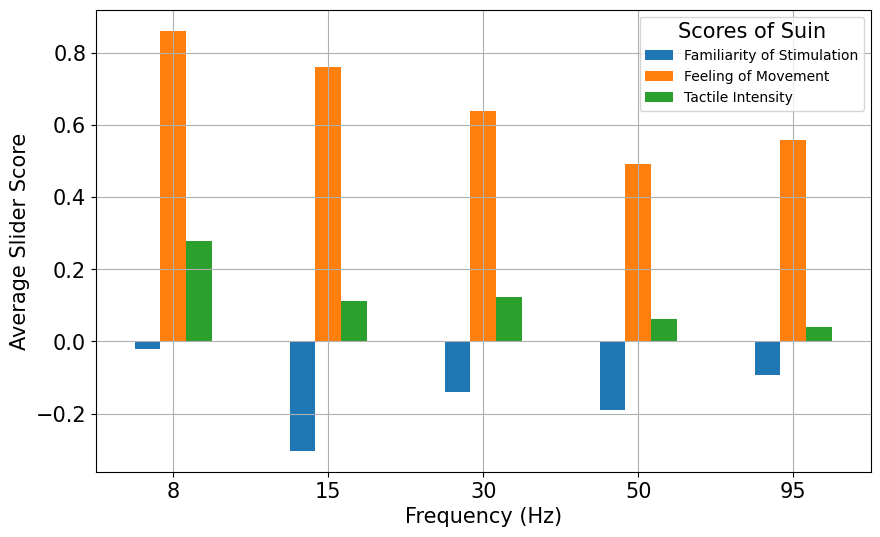

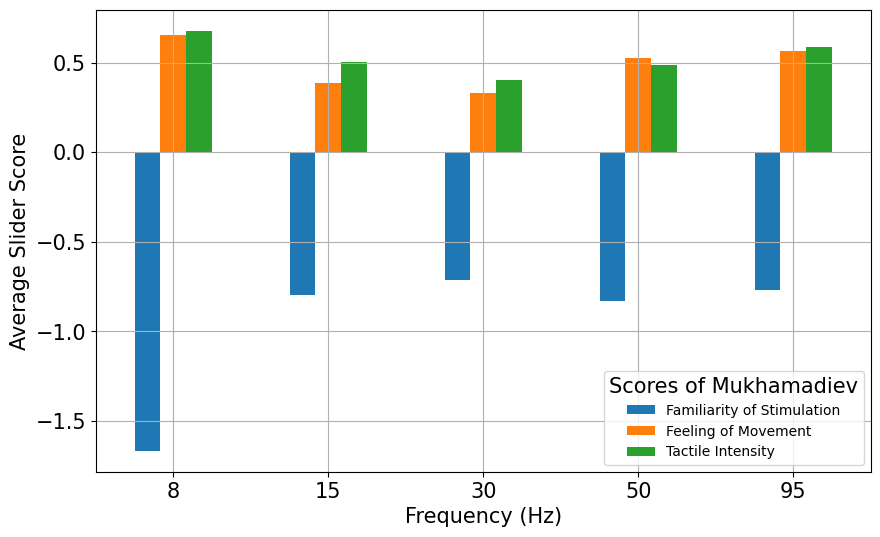

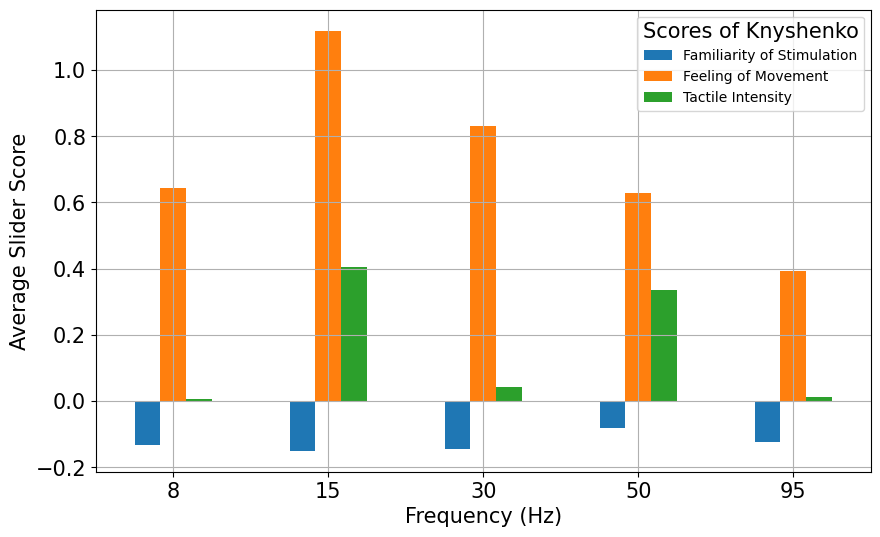

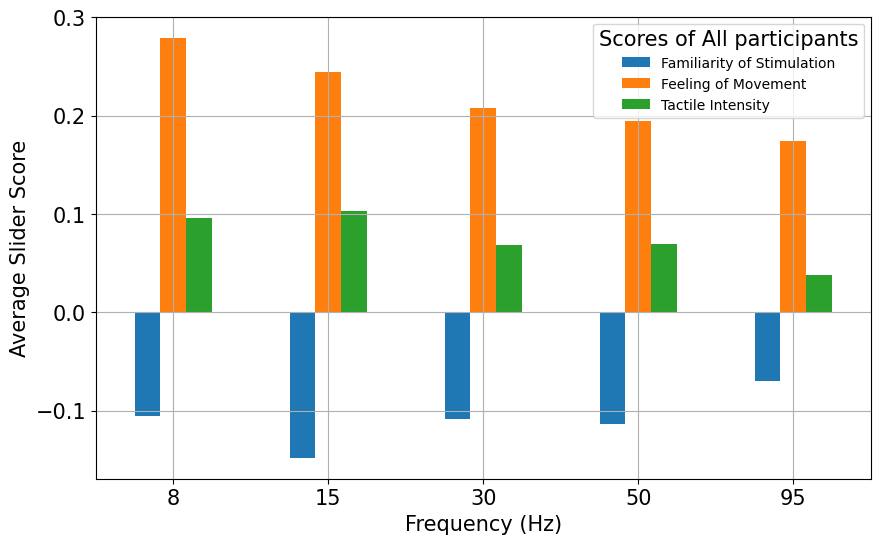

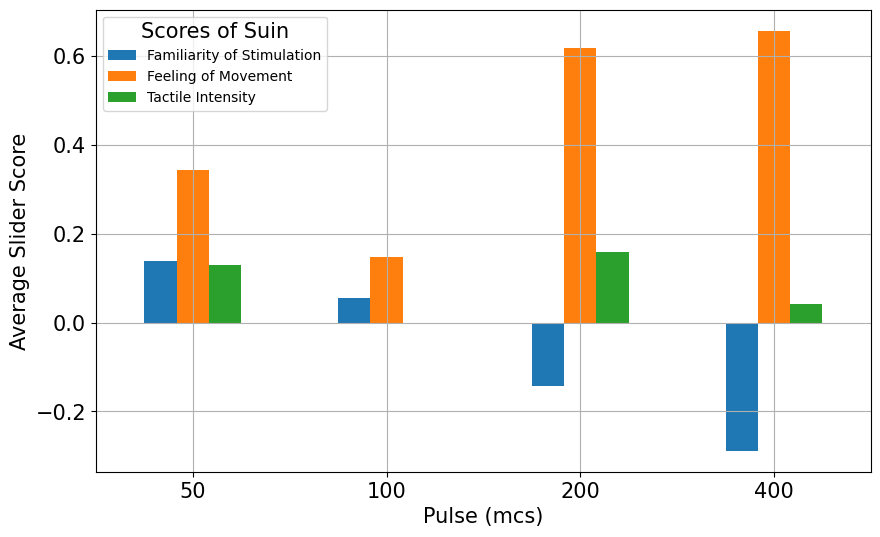

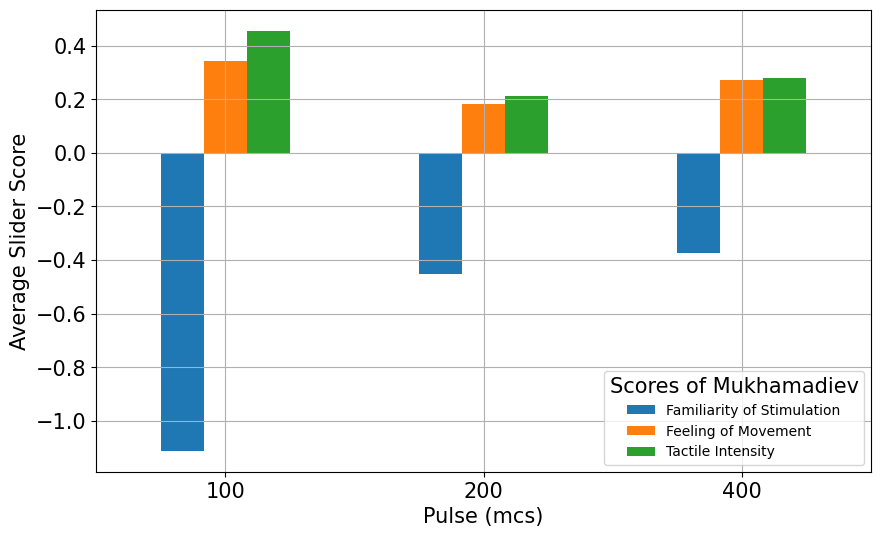

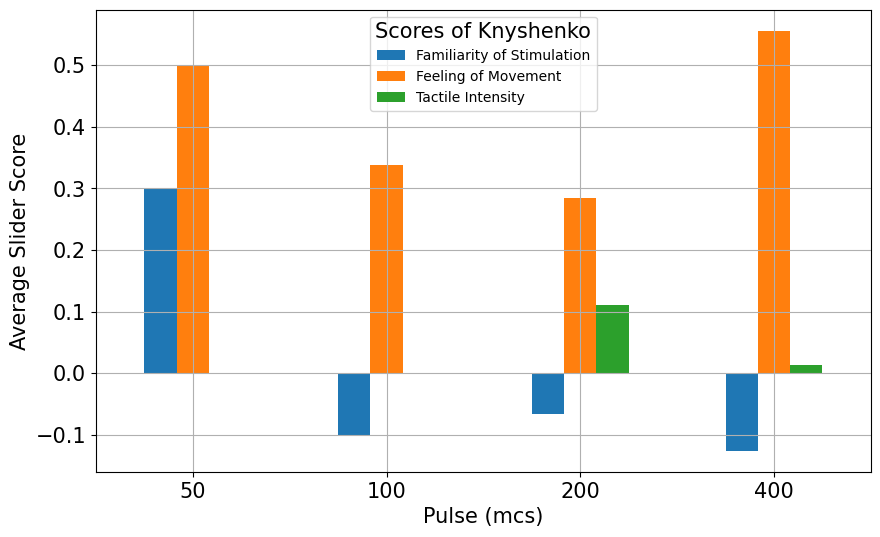

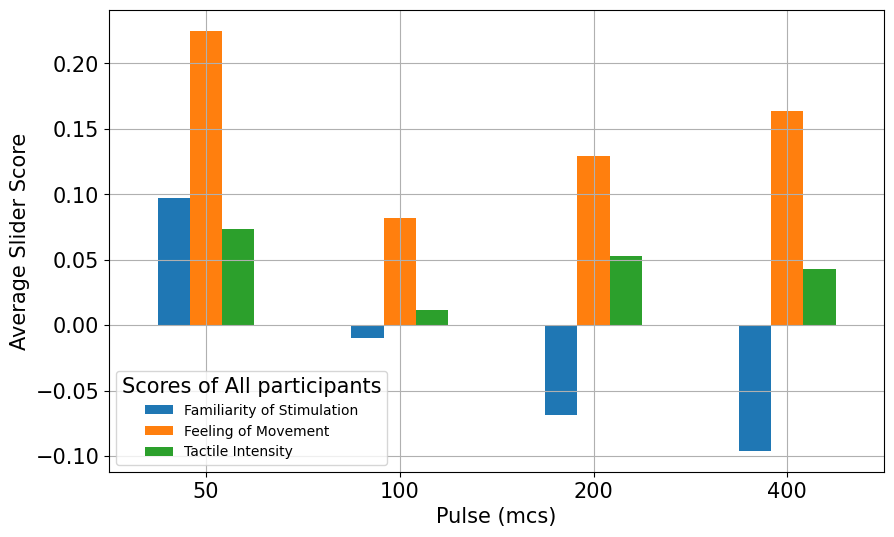

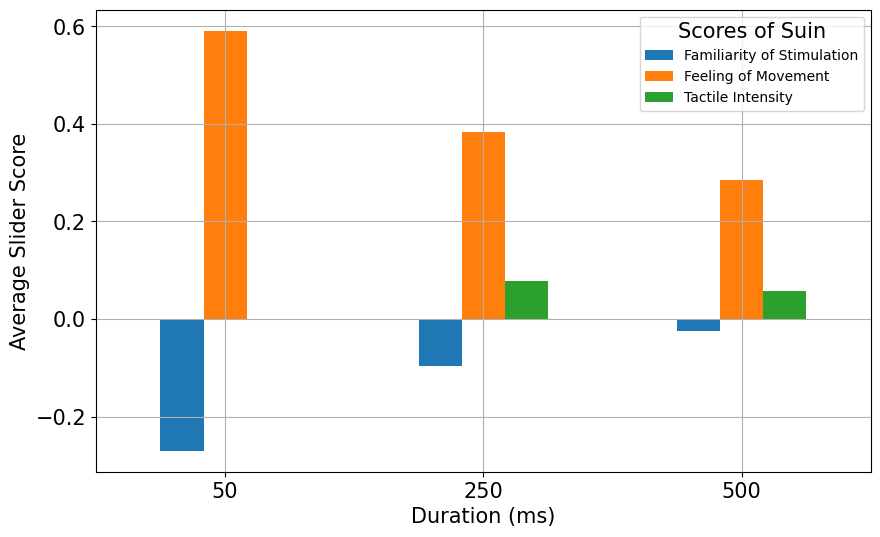

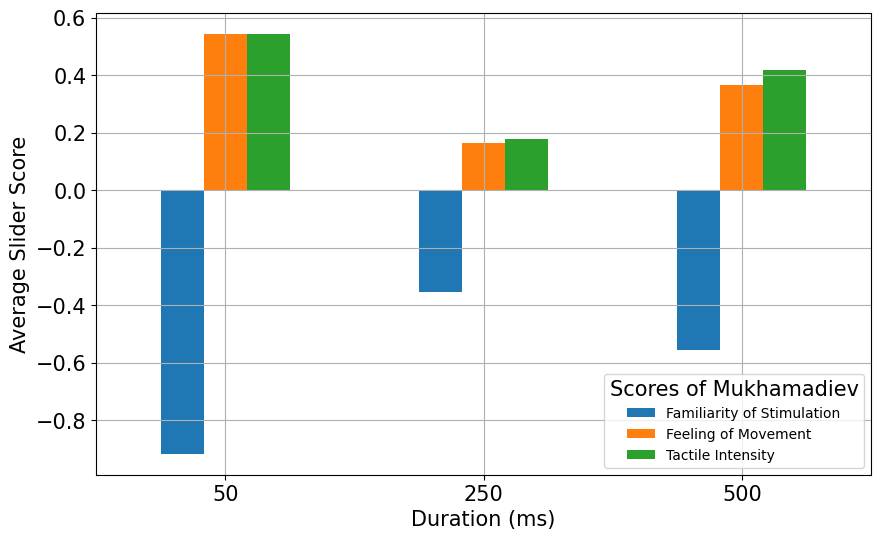

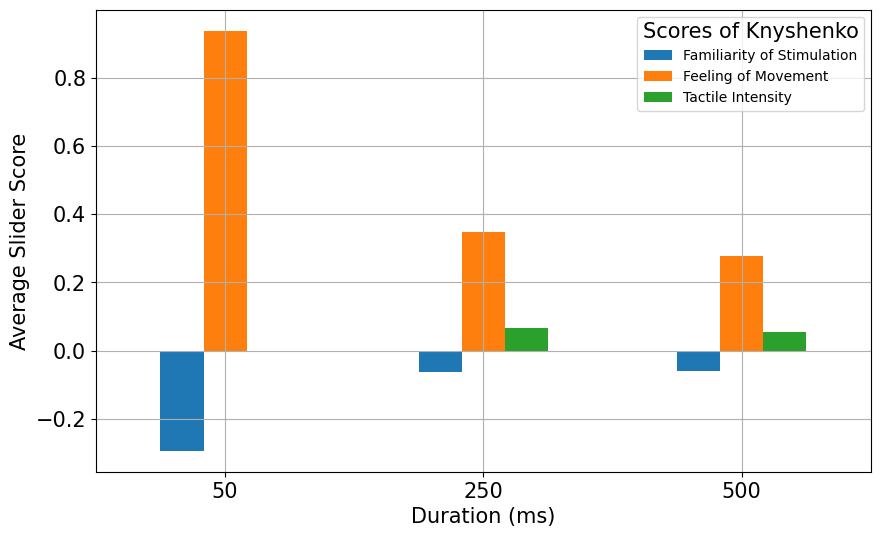

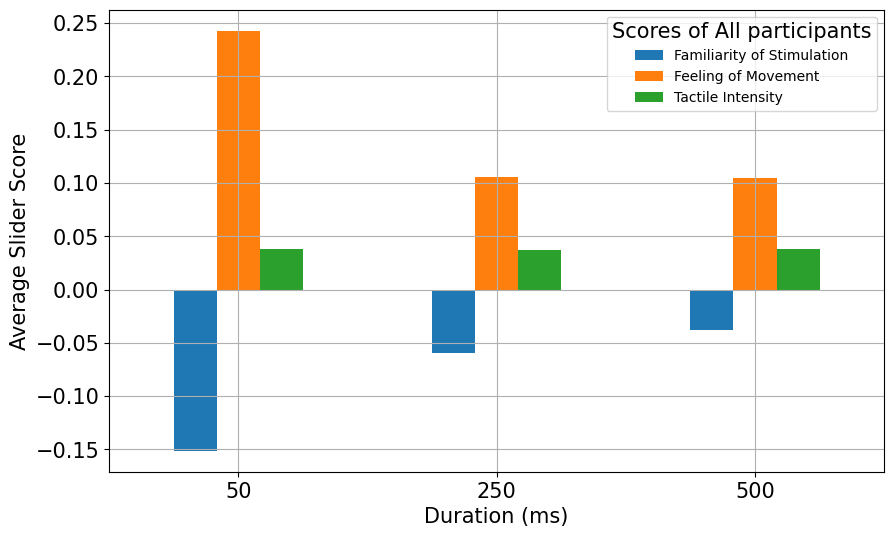

In [18]:
# Mean Value
for param in ['Frequency', 'Pulse', 'Duration']:
    for i, name in enumerate(participants):
        
        #print(f'\n{name}--{param}')
        ax = (data_per_participant['Data'][i][f'{param}_mean'] / data_per_participant['Data'][i][f'{param}_count']).plot.bar(figsize=(10, 6))
        ax.grid()
        ax.legend(title='Scores of ' + name, labels=['Familiarity of Stimulation', 'Feeling of Movement', 'Tactile Intensity'], fontsize=10)
        ax.get_legend().get_title().set_fontsize('15')
        ax.set_ylabel('Average Slider Score', fontsize=15)
        if param == 'Frequency':
            label = param + ' (Hz)'
        elif param == 'Pulse':
            label = param + ' (mcs)'
        elif param == 'Duration':
            label = param + ' (ms)'
        ax.set_xlabel(label, fontsize=15)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=15, rotation=0)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)

    #print(f'\nAll--{param}')
    all_val = Data_for_MainSliders.groupby(param).mean()[FIRST_PAGE_SLIDERS]
    all_score = Data_for_MainSliders.groupby(param).count()[FIRST_PAGE_SLIDERS]
    ax = (all_val / all_score).plot.bar(figsize=(10, 6))
    ax.grid()
    ax.legend(title='Scores of All participants', labels=['Familiarity of Stimulation', 'Feeling of Movement', 'Tactile Intensity'], fontsize=10)
    ax.get_legend().get_title().set_fontsize('15')
    ax.set_ylabel('Average Slider Score', fontsize=15)
    if param == 'Frequency':
        label = param + ' (Hz)'
    elif param == 'Pulse':
        label = param + ' (mcs)'
    elif param == 'Duration':
        label = param + ' (ms)'
    ax.set_xlabel(label, fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=15, rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)


Median Value Plot

C:\Users\asus\AppData\Local\Temp\ipykernel_15240\2924784435.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
C:\Users\asus\AppData\Local\Temp\ipykernel_15240\2924784435.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)


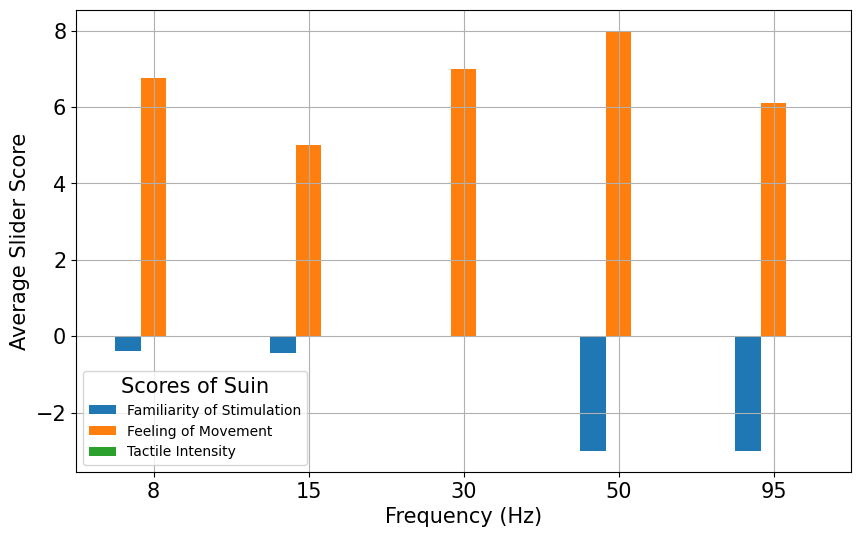

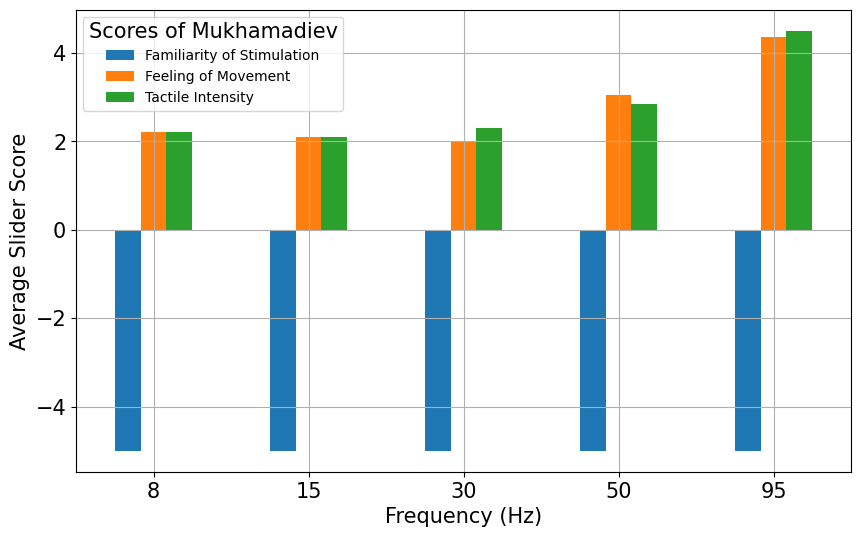

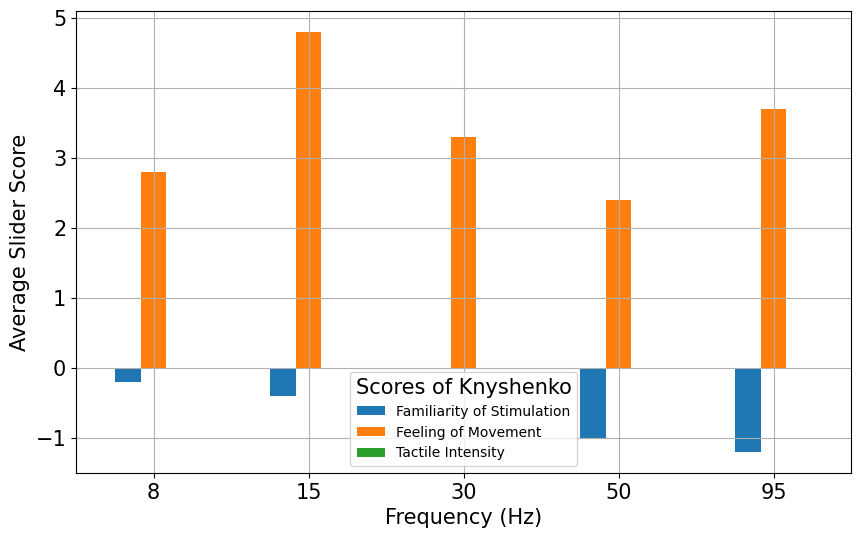

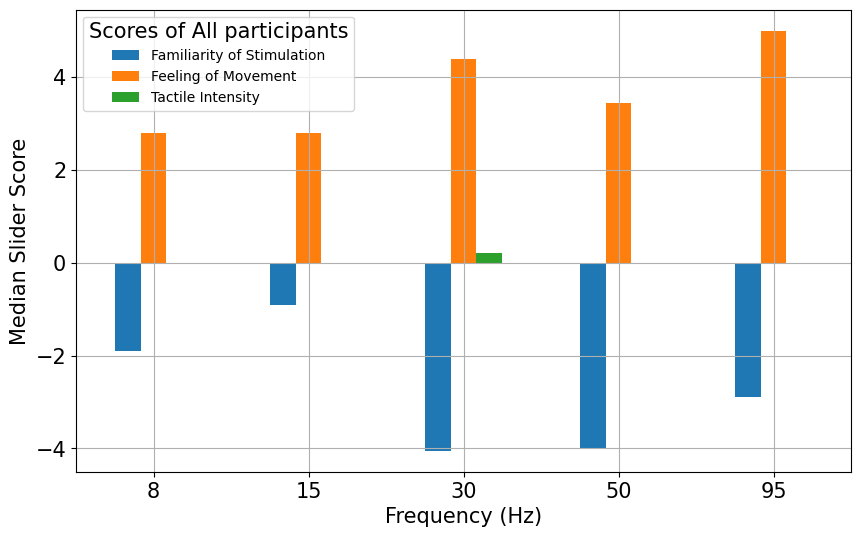

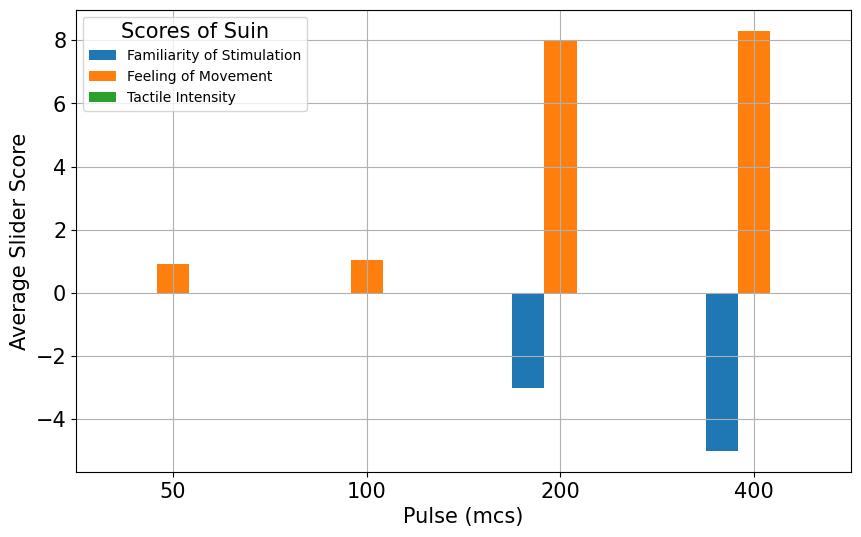

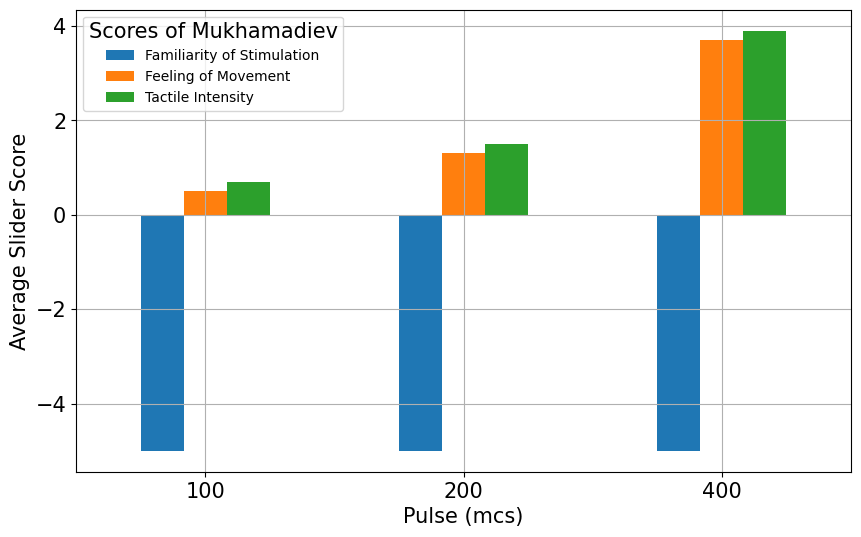

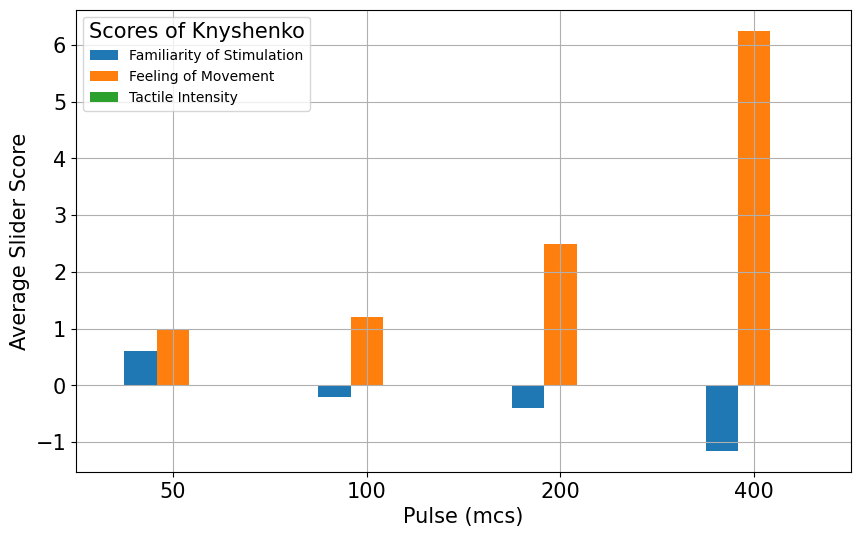

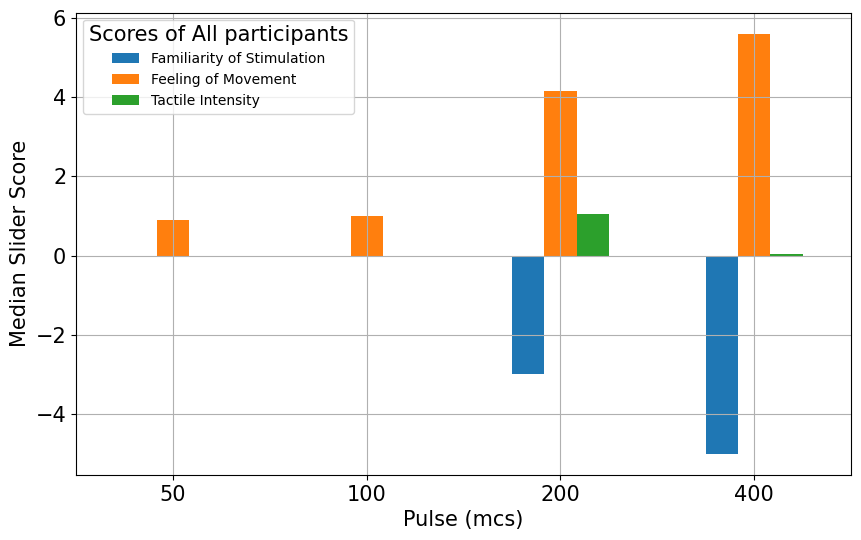

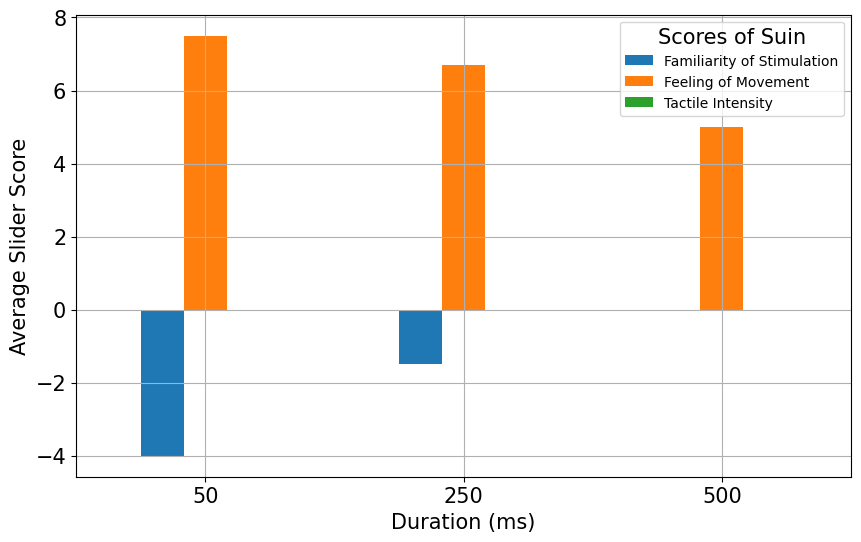

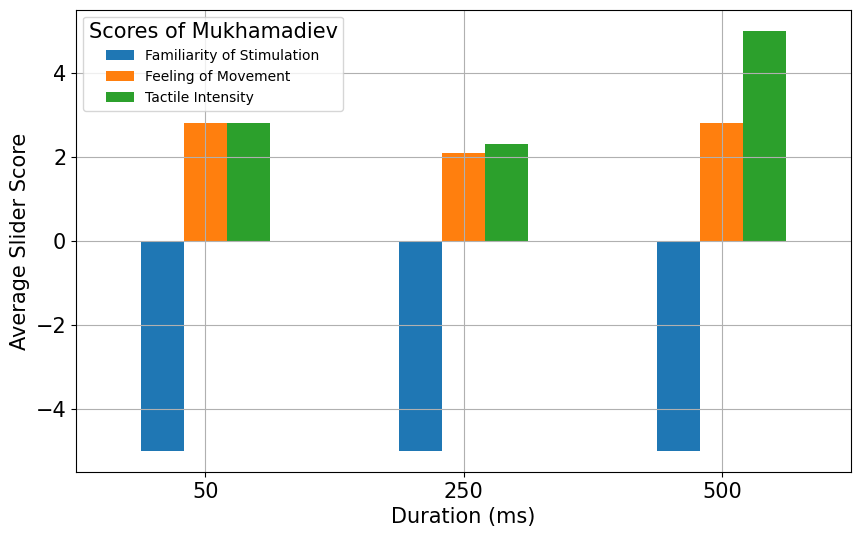

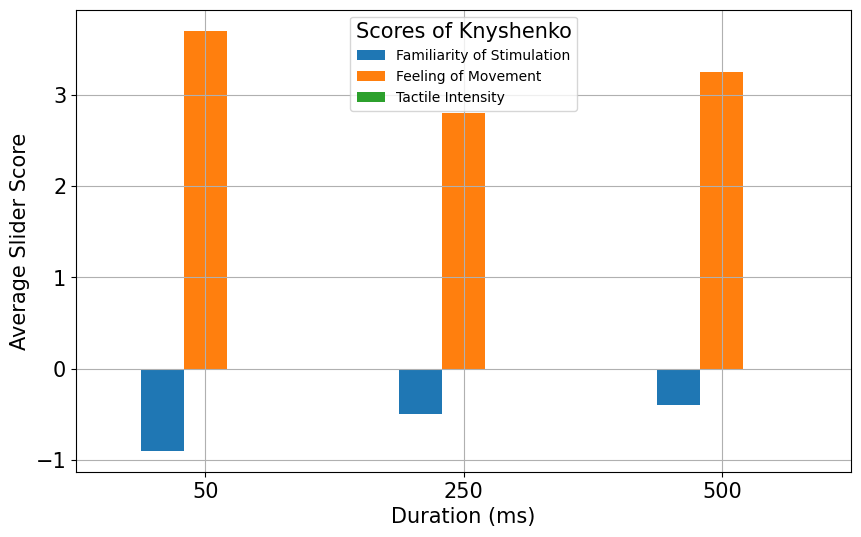

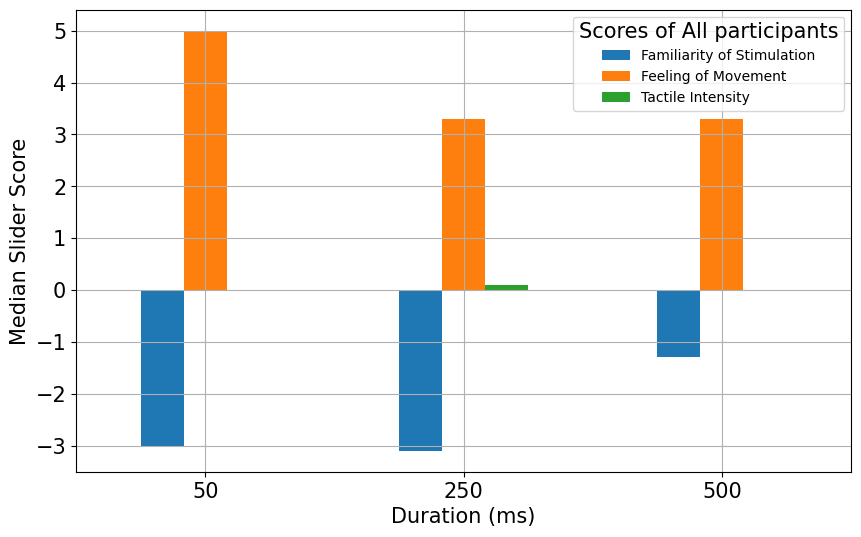

In [25]:
for param in ['Frequency', 'Pulse', 'Duration']:
    for i, name in enumerate(participants):
        #ax = (data_per_participant['Data'][i][f'{param}_median'] / data_per_participant['Data'][i][f'{param}_count']).plot.bar(figsize=(10, 6))
        ax = (data_per_participant['Data'][i][f'{param}_median']).plot.bar(figsize=(10, 6))
        ax.grid()
        ax.legend(title='Scores of ' + name, labels=['Familiarity of Stimulation', 'Feeling of Movement', 'Tactile Intensity'], fontsize=10)
        ax.get_legend().get_title().set_fontsize('15')
        ax.set_ylabel('Average Slider Score', fontsize=15)
        if param == 'Frequency':
            label = param + ' (Hz)'
        elif param == 'Pulse':
            label = param + ' (mcs)'
        elif param == 'Duration':
            label = param + ' (ms)'
        ax.set_xlabel(label, fontsize=15)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=15, rotation=0)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
        
    all_val = Data_for_MainSliders.groupby(param).median()[FIRST_PAGE_SLIDERS]
    all_score = Data_for_MainSliders.groupby(param).count()[FIRST_PAGE_SLIDERS]
    #ax = (all_val / all_score).plot.bar(figsize=(10, 6))
    ax = (all_val).plot.bar(figsize=(10, 6))
    ax.grid()
    ax.legend(title='Scores of All participants', labels=['Familiarity of Stimulation', 'Feeling of Movement', 'Tactile Intensity'], fontsize=10)
    ax.get_legend().get_title().set_fontsize('15')
    ax.set_ylabel('Median Slider Score', fontsize=15)
    if param == 'Frequency':
        label = param + ' (Hz)'
    elif param == 'Pulse':
        label = param + ' (mcs)'
    elif param == 'Duration':
        label = param + ' (ms)'
    ax.set_xlabel(label, fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=15, rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)


Замена участников индексами

In [26]:
Data_for_MainSliders.loc[Data_for_MainSliders['Participant'] == 'Knyshenko', "Participant"] = '1'
Data_for_MainSliders.loc[Data_for_MainSliders['Participant'] == 'Mukhamadiev', "Participant"] = '2'
Data_for_MainSliders.loc[Data_for_MainSliders['Participant'] == 'Suin', "Participant"] = '3'
MainSliders = pd.DataFrame()

for i in range(3):
    Data_for_MainSliders_temp = Data_for_MainSliders[Data_for_MainSliders['Participant'] == str(i+1)]
    for name in FIRST_PAGE_SLIDERS:
        df = Data_for_MainSliders_temp[name]
        Data_for_MainSliders_temp[name]=(df-df.min())/(df.max()-df.min())
    MainSliders = pd.concat([MainSliders, Data_for_MainSliders_temp], axis=0)

MainSliders

C:\Users\asus\AppData\Local\Temp\ipykernel_15240\2511074458.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_for_MainSliders_temp[name]=(df-df.min())/(df.max()-df.min())


,Participant,Pulse,Frequency,Duration,Familiarity of Stimulation,Feeling of Movement,Tactile Intensity
1,1,200,50,500,0.551724,1.000000,0.752809
4,1,200,15,250,0.431034,0.773810,0.662921
5,1,400,95,500,0.310345,0.142857,1.000000
6,1,400,30,250,0.258621,0.000000,0.752809
11,1,200,95,50,0.793103,0.000000,0.516854
...,...,...,...,...,...,...,...
306,3,400,50,500,0.000000,0.362500,1.000000
307,3,100,50,50,0.500000,0.000000,0.000000
308,3,400,30,250,0.000000,0.287500,0.810000
309,3,100,15,500,0.410000,0.000000,0.100000


In [30]:
type(MainSliders.iloc[1][4])

numpy.float64

SNS boxplot with normalization by participant

In [27]:
exp = os.getcwd() + '\Data prepared\Plots'
exp

'c:\\Users\\asus\\0_LAB\\Neurotech\\Project\\TENSense\\Analysis\\Data prepared\\Plots'

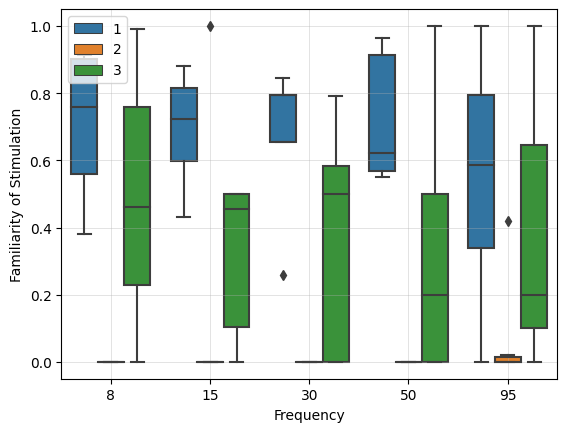

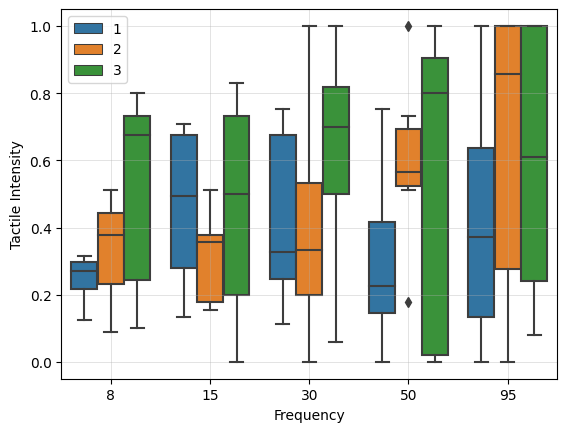

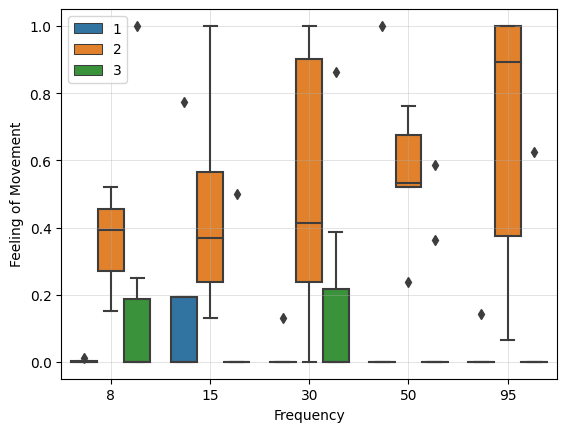

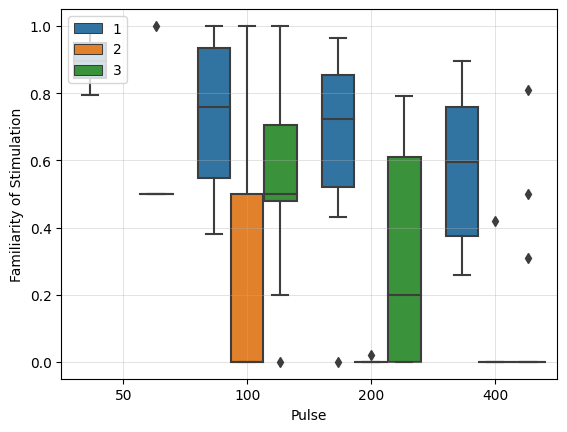

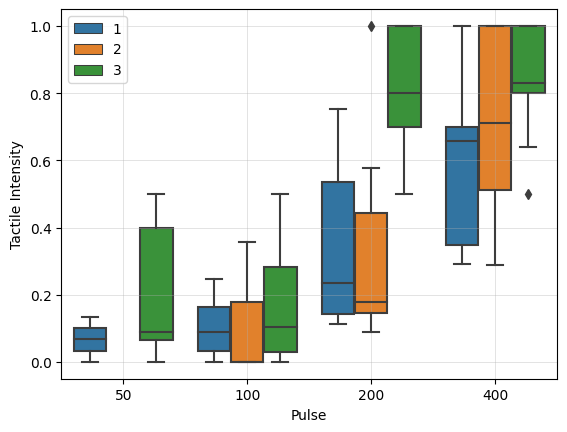

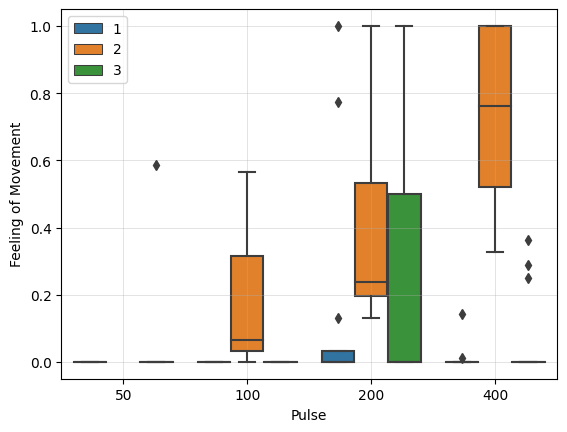

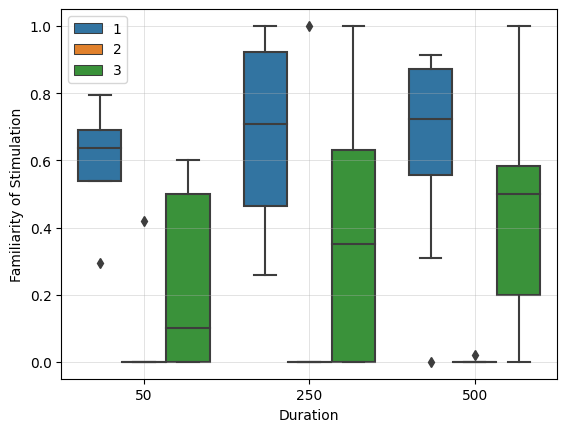

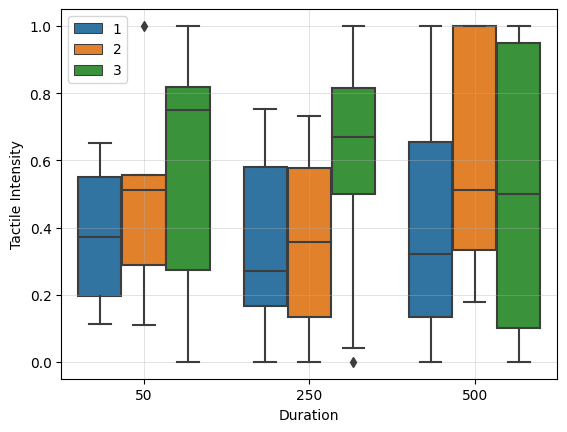

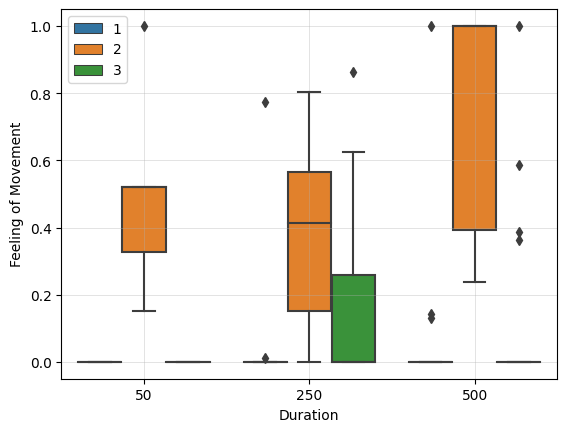

In [39]:
for param in ['Frequency', 'Pulse', 'Duration']:
    for tact in FIRST_PAGE_SLIDERS:
        sns.boxplot(data=MainSliders, x=param, y=tact, hue="Participant", dodge=True)
        plt.grid(alpha = 0.5, linewidth=0.5)
        plt.legend(loc='upper left')
        plt.show()
        #plt.savefig(exp + f'\_Normalized_{tact}_{param}.png')
        #plt.close()

SNS boxplot without normalization

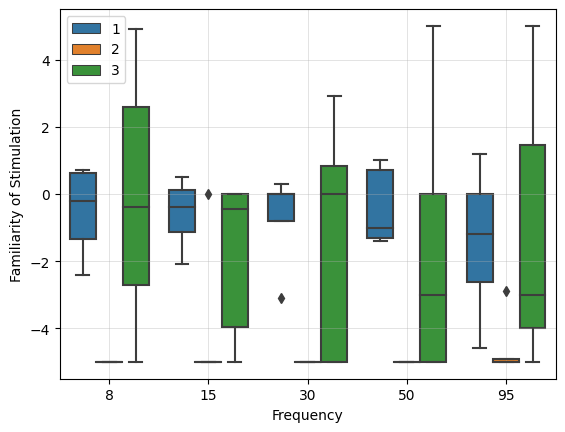

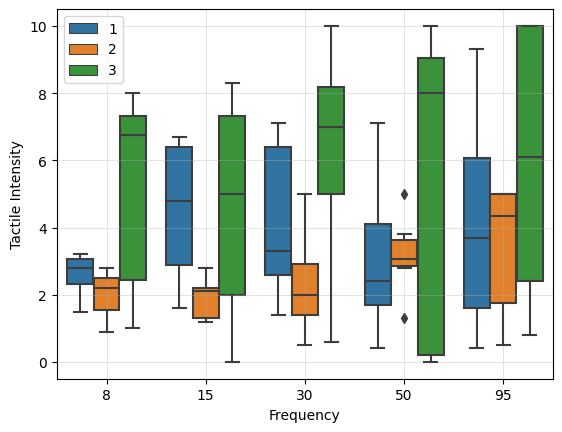

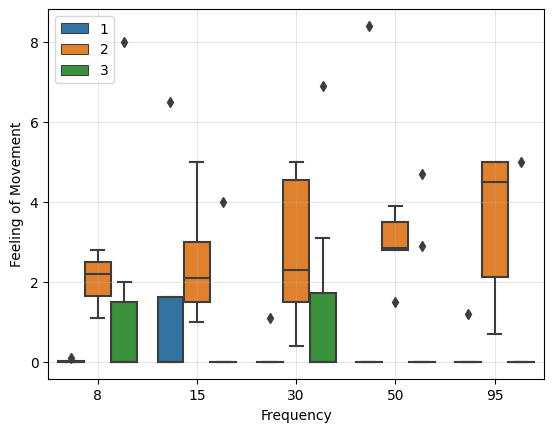

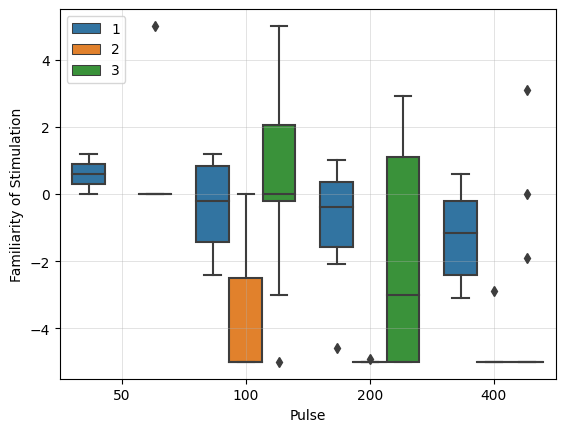

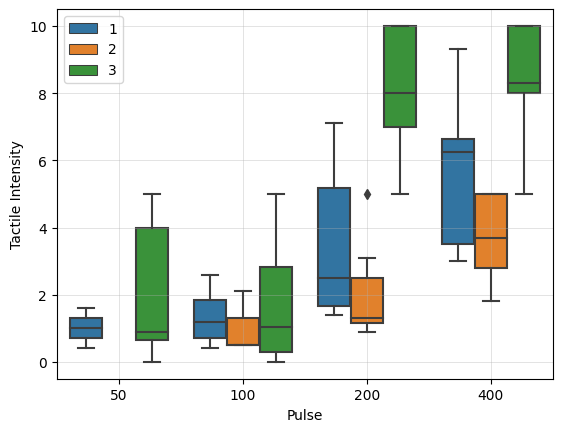

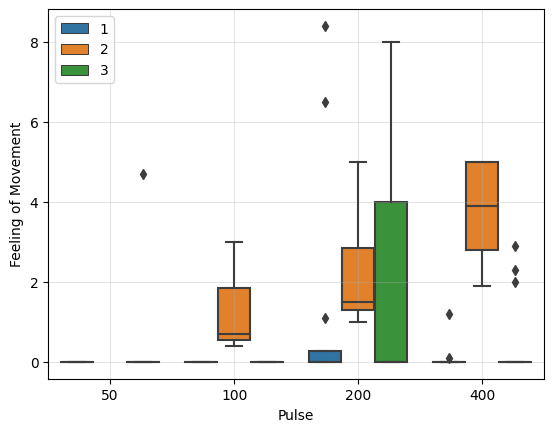

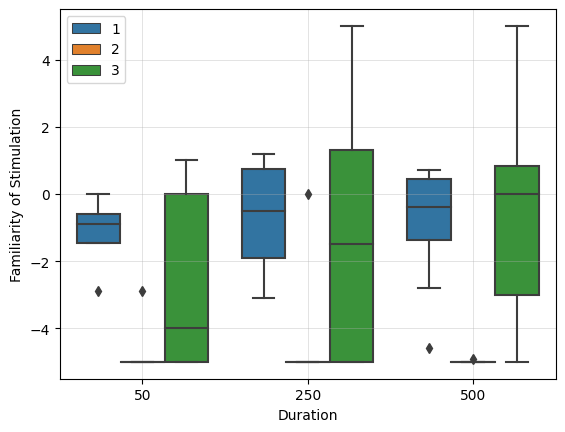

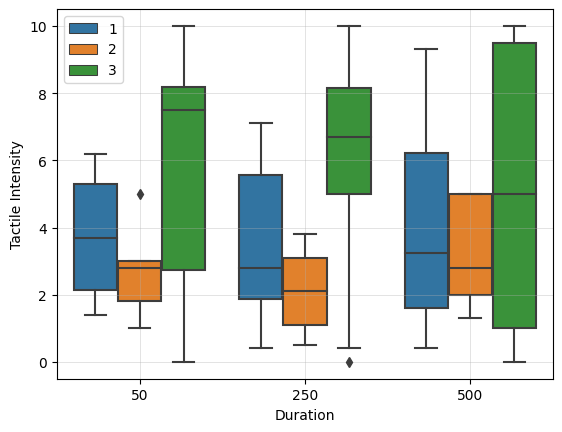

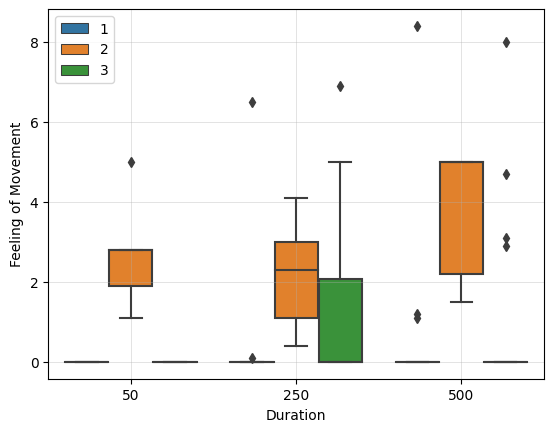

In [32]:
for param in ['Frequency', 'Pulse', 'Duration']:
    for tact in FIRST_PAGE_SLIDERS:
        sns.boxplot(data=Data_for_MainSliders, x=param, y=tact, hue="Participant", dodge=True)
        plt.grid(alpha = 0.5, linewidth=0.5)
        plt.legend(loc='upper left')
        plt.show()
        #plt.savefig(exp + f'\_Un_Normalized_{tact}_{param}.png')
        #plt.close()


In [80]:
MainSliders

,Participant,Pulse,Frequency,Duration,Familiarity of Stimulation,Feeling of Movement,Tactile Intensity
1,1,200,50,500,0.551724,1.000000,0.752809
4,1,200,15,250,0.431034,0.773810,0.662921
5,1,400,95,500,0.310345,0.142857,1.000000
6,1,400,30,250,0.258621,0.000000,0.752809
11,1,200,95,50,0.793103,0.000000,0.516854
...,...,...,...,...,...,...,...
306,3,400,50,500,0.000000,0.362500,1.000000
307,3,100,50,50,0.500000,0.000000,0.000000
308,3,400,30,250,0.000000,0.287500,0.810000
309,3,100,15,500,0.410000,0.000000,0.100000


In [81]:
FIRST_PAGE_SLIDERS

['Familiarity of Stimulation', 'Tactile Intensity', 'Feeling of Movement']

In [ ]:
import random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

Data_felt_for_Feel_Pics = pd.read_csv('Temp.csv')


drop2 = [['Feeling of Movement', 'Tactile Intensity'],
         ['Familiarity of Stimulation', 'Tactile Intensity'],
         ['Familiarity of Stimulation', 'Feeling of Movement']]

Data_dict = {'Familiarity of Stimulation': '','2': '','3': ''}
for w in range(len(drop2)):
    # for ww in range(len(drop2)):
    #     drop2[w][ww] = 'PredR ' + drop2[w][ww]
    Data_dict[str(w+1)] = Data_felt_for_Feel_Pics.drop(columns=drop2[w])
    np_f = Data_dict[str(w+1)].to_numpy()
    key_list = list(Data_dict[str(w+1)].keys())


    full_feel = []
    full_t = np_f.tolist()
    for j in range(np_f.shape[0]):
        temp = []
        temp_temp = []
        temp_feel = []
        for i in range(np_f.shape[1]):
            if i < 4:
                temp.append(full_t[j][i])
                temp_temp.append(full_t[j][i])
            if i >=4:
                if full_t[j][i] == 1.0:
                    temp_feel.append(key_list[i].split(' ')[1])
                if i == np_f.shape[1]-1:
                    full_feel.append(temp_feel)
    
    full = []
    for j in range(np_f.shape[0]):
        temp = []
        temp_temp = []
        temp_feel = []
        for i in range(4):
            if i < 4:
                temp.append(full_t[j][i])
        
        for name in full_feel[j]:
            temp.append(name)
            full.append(temp)
            temp = temp[:-1]
            for s in range(len(temp)):
                # if s > 0 and s < 3:
                #     temp[s] = float(temp[s] + random.randint(-20,20)/10)
                if s == 1:
                    temp[s] = float(temp[s] + random.randint(-40,40)/2)
                if s == 2:
                    temp[s] = float(temp[s] + random.randint(-30,30)/10)
                if s == 3:
                    temp[s] = float(temp[s] + random.randint(-60,60)/2)
                

    full = np.array(full)
    Data_dict[str(w+1)] = pd.DataFrame(full, columns=['Participant', 'Pulse', 'Frequency', 'Duration', 'Regions'])
    Data_dict[str(w+1)] = Data_dict[str(w+1)].astype({'Frequency': float, 'Pulse': float})

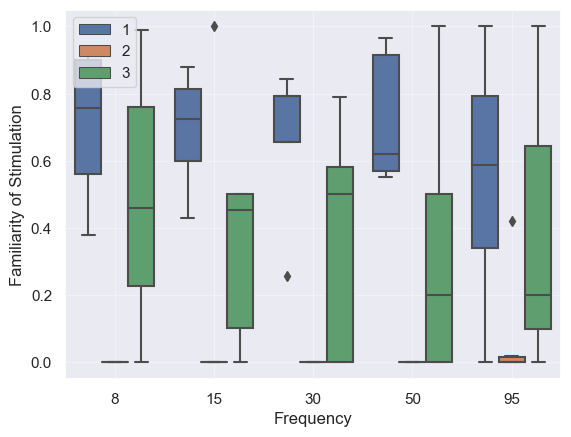

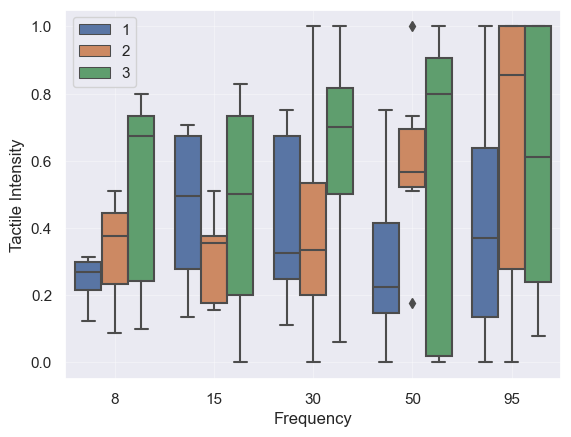

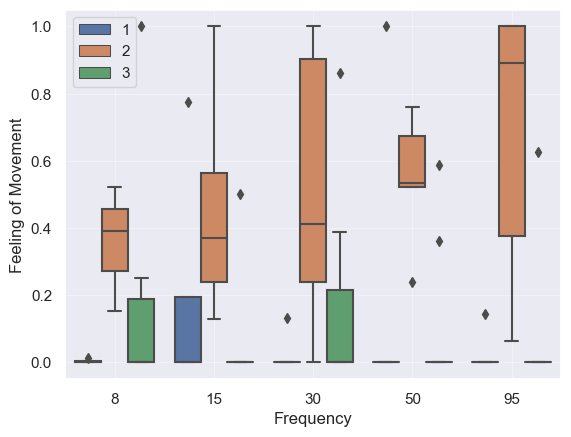

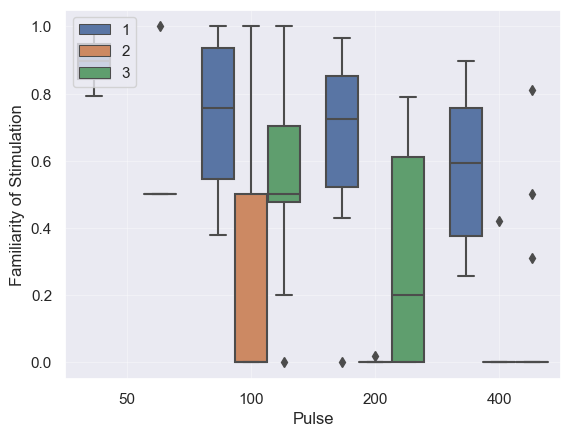

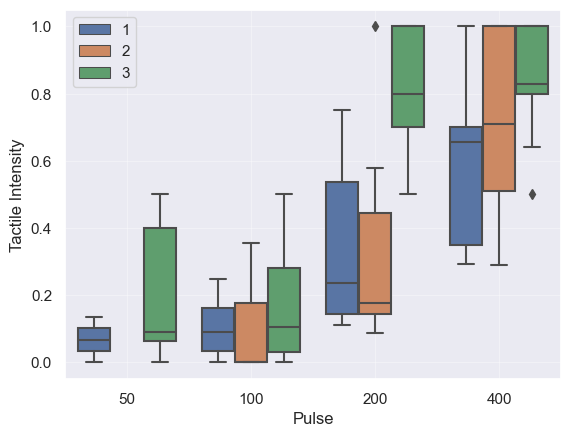

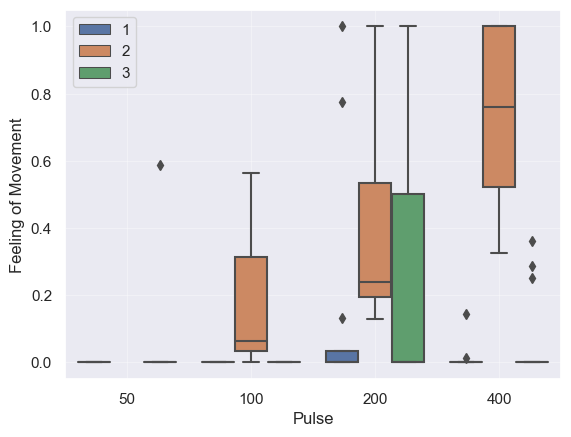

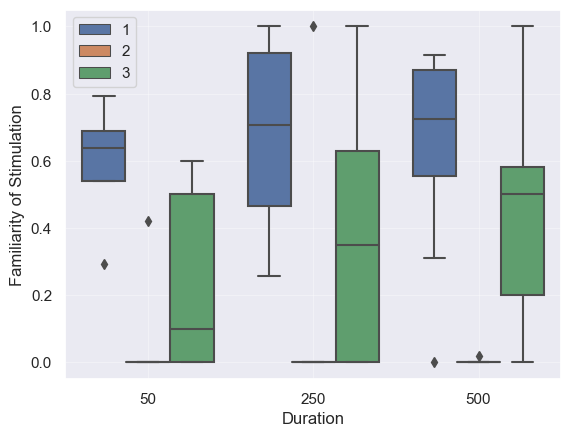

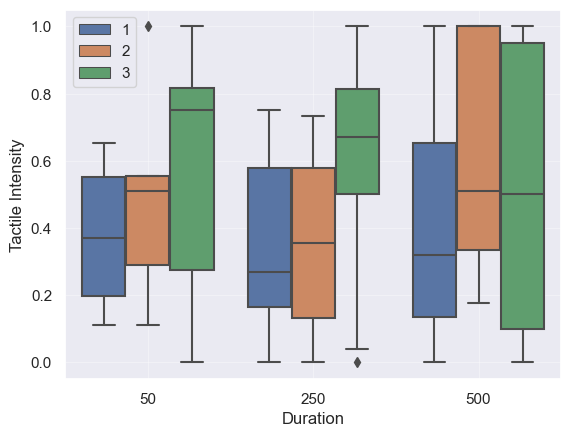

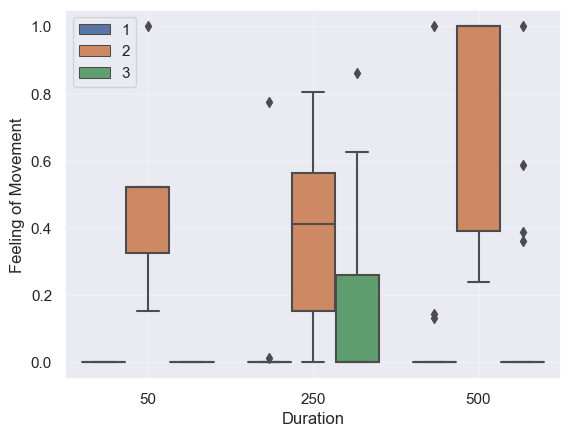

In [79]:

for param in ['Frequency', 'Pulse', 'Duration']:
    for tact in FIRST_PAGE_SLIDERS:
        sns.boxplot(data=MainSliders, x=param, y=tact, hue="Participant", dodge=True)
        plt.grid(alpha = 0.5, linewidth=0.5)
        plt.legend(loc='upper left')
        plt.show()
        #plt.savefig(exp + f'\_Un_Normalized_{tact}_{param}.png')
        #plt.close()


Выделение данных только для ощущений

In [34]:
Data_felt_for_Feel = Data_felt

keys_list = list(Data_felt_for_Feel.keys())
for name in keys_list:
    if 'PredR' in name:
        Data_felt_for_Feel = Data_felt_for_Feel.drop(columns = [name])

Data_felt_for_Feel = Data_felt_for_Feel.drop(columns = ['Picture', 'Familiarity of Stimulation', 'Painfulness', 'Phantom Pain Intensity',
                                                        'Feeling of Movement', 'Temperature Changes', 'Tactile Intensity', 'Was Felt'])

In [ ]:
exp = os.getcwd() + '\Data prepared'
exp

Data_felt_for_Feel.to_csv(exp + '\For_feelings.csv', index=False)

Графики для презентации ощущений

In [35]:
exp = os.getcwd() + '\Data prepared'
exp

FIRST_PAGE_SLIDERS = ['Familiarity of Stimulation', 'Tactile Intensity', 'Feeling of Movement']

Data_felt_for_Feel = pd.read_csv(exp + '\For_feelings.csv')

In [37]:
Data_felt_for_Feel

,Participant,Pulse,Frequency,Duration,Vibration,Twitching,Intention to Make Movement,Touch,Squeezing,Puncture,Prickling,Electric Current,Hit,Pulsation,Tickling,Itching,Tingling,Numbness,Muscle contraction,PicList
0,1,200,50,500,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,1 5 6 9 10 11 16
1,1,200,15,250,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,5 6 10 11 16
2,1,400,95,500,True,False,False,False,False,False,True,True,False,True,False,True,False,False,False,1 5 6 9 10 11 12 13 16
3,1,400,30,250,True,True,False,False,False,False,True,True,False,True,False,True,False,False,False,1 3 5 6 9 10 11 12 13 16
4,1,200,95,50,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,5 6 9 10 11 12 13 16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,3,400,50,500,True,True,False,False,True,False,True,False,True,True,False,False,False,True,False,1 3 4 5 6 7 8 9 10 11 12 13 14 16 17
95,3,100,50,50,True,True,False,False,True,False,True,False,True,True,False,False,False,True,False,9 16 17
96,3,400,30,250,False,True,False,False,False,False,True,False,True,True,False,False,False,True,False,5 6 7 10 11 12 13 14
97,3,100,15,500,False,True,False,False,False,False,True,False,True,True,True,False,False,True,False,16 17


In [40]:
to_x = ['Electric Current', 'Hit', 'Intention to Make Movement',
        'Itching', 'Muscle contraction', 'Numbness', 'Prickling',
        'Pulsation', 'Puncture', 'Squeezing', 'Tickling',
        'Tingling', 'Touch', 'Twitching', 'Vibration']

Data_felt_for_Feel_Without_Pics = Data_felt_for_Feel.drop(columns='PicList')
display(Data_felt_for_Feel_Without_Pics)

Data_felt_for_Feel_Pics = Data_felt_for_Feel.drop(columns=to_x)
Data_felt_for_Feel_Pics

,Participant,Pulse,Frequency,Duration,Vibration,Twitching,Intention to Make Movement,Touch,Squeezing,Puncture,Prickling,Electric Current,Hit,Pulsation,Tickling,Itching,Tingling,Numbness,Muscle contraction
0,1,200,50,500,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False
1,1,200,15,250,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False
2,1,400,95,500,True,False,False,False,False,False,True,True,False,True,False,True,False,False,False
3,1,400,30,250,True,True,False,False,False,False,True,True,False,True,False,True,False,False,False
4,1,200,95,50,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,3,400,50,500,True,True,False,False,True,False,True,False,True,True,False,False,False,True,False
95,3,100,50,50,True,True,False,False,True,False,True,False,True,True,False,False,False,True,False
96,3,400,30,250,False,True,False,False,False,False,True,False,True,True,False,False,False,True,False
97,3,100,15,500,False,True,False,False,False,False,True,False,True,True,True,False,False,True,False


,Participant,Pulse,Frequency,Duration,PicList
0,1,200,50,500,1 5 6 9 10 11 16
1,1,200,15,250,5 6 10 11 16
2,1,400,95,500,1 5 6 9 10 11 12 13 16
3,1,400,30,250,1 3 5 6 9 10 11 12 13 16
4,1,200,95,50,5 6 9 10 11 12 13 16
...,...,...,...,...,...
94,3,400,50,500,1 3 4 5 6 7 8 9 10 11 12 13 14 16 17
95,3,100,50,50,9 16 17
96,3,400,30,250,5 6 7 10 11 12 13 14
97,3,100,15,500,16 17


In [57]:
np_f = Data_felt_for_Feel_Without_Pics.to_numpy()
key_list = list(Data_felt_for_Feel_Without_Pics.keys())
np_f.shape

(99, 19)

In [58]:
import random

drop2 = [['Itching', 'Muscle contraction', 'Numbness', 'Prickling', 'Pulsation', 'Puncture', 'Squeezing', 'Tickling', 'Tingling', 'Touch', 'Twitching', 'Vibration'],
        ['Electric Current', 'Hit', 'Intention to Make Movement', 'Pulsation', 'Puncture', 'Squeezing', 'Tickling', 'Tingling', 'Touch', 'Twitching', 'Vibration'],
        ['Electric Current', 'Hit', 'Intention to Make Movement', 'Itching', 'Muscle contraction', 'Numbness', 'Prickling', 'Tingling', 'Touch', 'Twitching', 'Vibration'],
        ['Electric Current', 'Hit', 'Intention to Make Movement', 'Itching', 'Muscle contraction', 'Numbness', 'Prickling', 'Pulsation', 'Puncture', 'Squeezing', 'Tickling']]

Data_dict = {'1': '','2': '','3': '','4': ''}
for w in range(len(drop2)):
    Data_dict[str(w+1)] = Data_felt_for_Feel_Without_Pics.drop(columns=drop2[w])
    np_f = Data_dict[str(w+1)].to_numpy()
    key_list = list(Data_dict[str(w+1)].keys())


    full_feel = []
    full_t = np_f.tolist()
    for j in range(np_f.shape[0]):
        temp = []
        temp_temp = []
        temp_feel = []
        for i in range(np_f.shape[1]):
            if i < 4:
                temp.append(full_t[j][i])
                temp_temp.append(full_t[j][i])
            if i >=4:
                if full_t[j][i] == True:
                    temp_feel.append(key_list[i])
                if i == np_f.shape[1]-1:
                    full_feel.append(temp_feel)

    full = []
    for j in range(np_f.shape[0]):
        temp = []
        temp_temp = []
        temp_feel = []
        for i in range(4):
            if i < 4:
                temp.append(full_t[j][i])
        
        for name in full_feel[j]:
            temp.append(name)
            full.append(temp)
            temp = temp[:-1]
            for s in range(len(temp)): 
                # if s > 0 and s < 3:
                #     temp[s] = float(temp[s] + random.randint(-20,20)/10)
                # Чтобы добавить распределения и было более презентабельно
                if s == 1:
                    temp[s] = float(temp[s] + random.randint(-40,40)/2)
                if s == 2:
                    temp[s] = float(temp[s] + random.randint(-30,30)/10)

    full = np.array(full)
    Data_dict[str(w+1)] = pd.DataFrame(full, columns=['Participant', 'Pulse', 'Frequency', 'Duration', 'Feelings'])
    Data_dict[str(w+1)] = Data_dict[str(w+1)].astype({'Frequency': float, 'Pulse': float})

In [59]:
for i in range(4):
    display(Data_dict[str(i+1)].groupby('Participant').count())
    #display(Data_dict[str(i+1)])

,Pulse,Frequency,Duration,Feelings
Participant,,,,
1,7,7,7,7
3,19,19,19,19


,Pulse,Frequency,Duration,Feelings
Participant,,,,
1,26,26,26,26
2,25,25,25,25
3,69,69,69,69


,Pulse,Frequency,Duration,Feelings
Participant,,,,
1,26,26,26,26
2,31,31,31,31
3,63,63,63,63


,Pulse,Frequency,Duration,Feelings
Participant,,,,
1,35,35,35,35
2,51,51,51,51
3,78,78,78,78


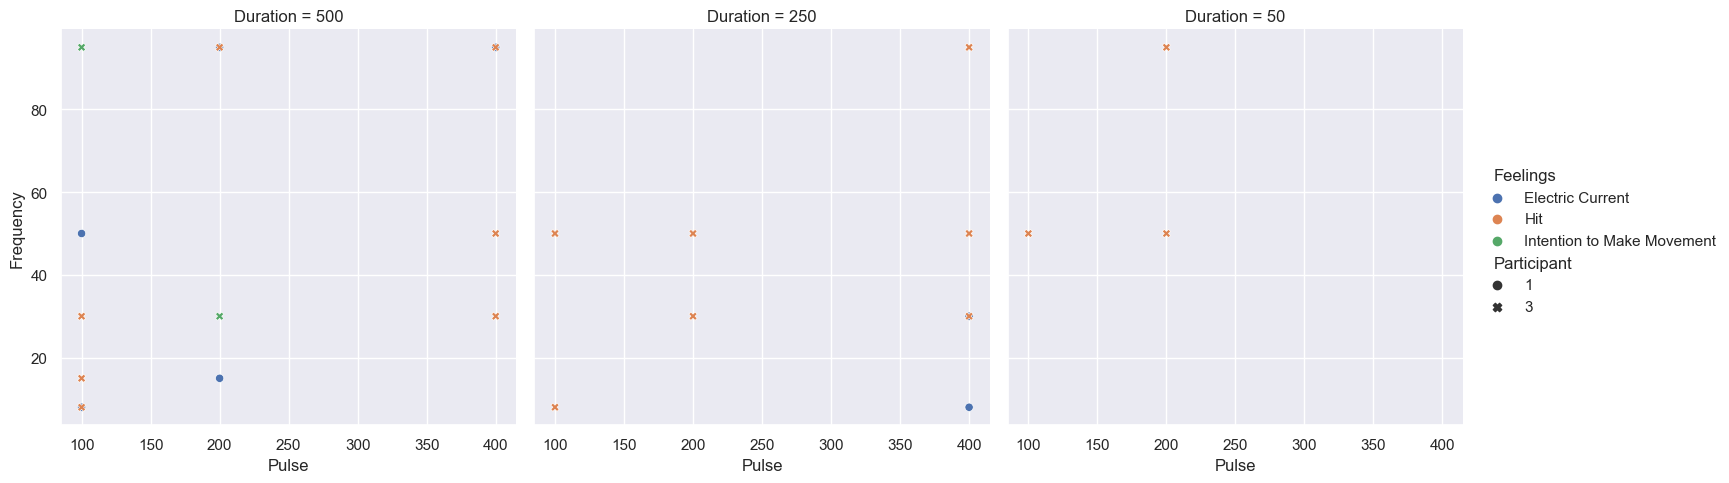

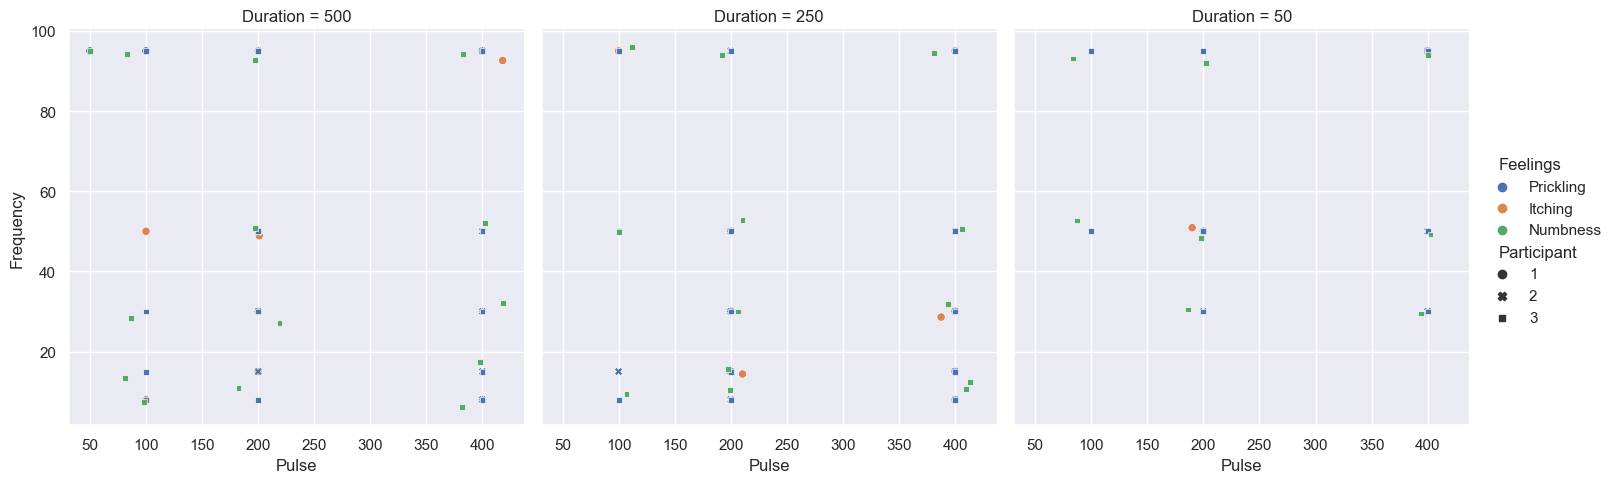

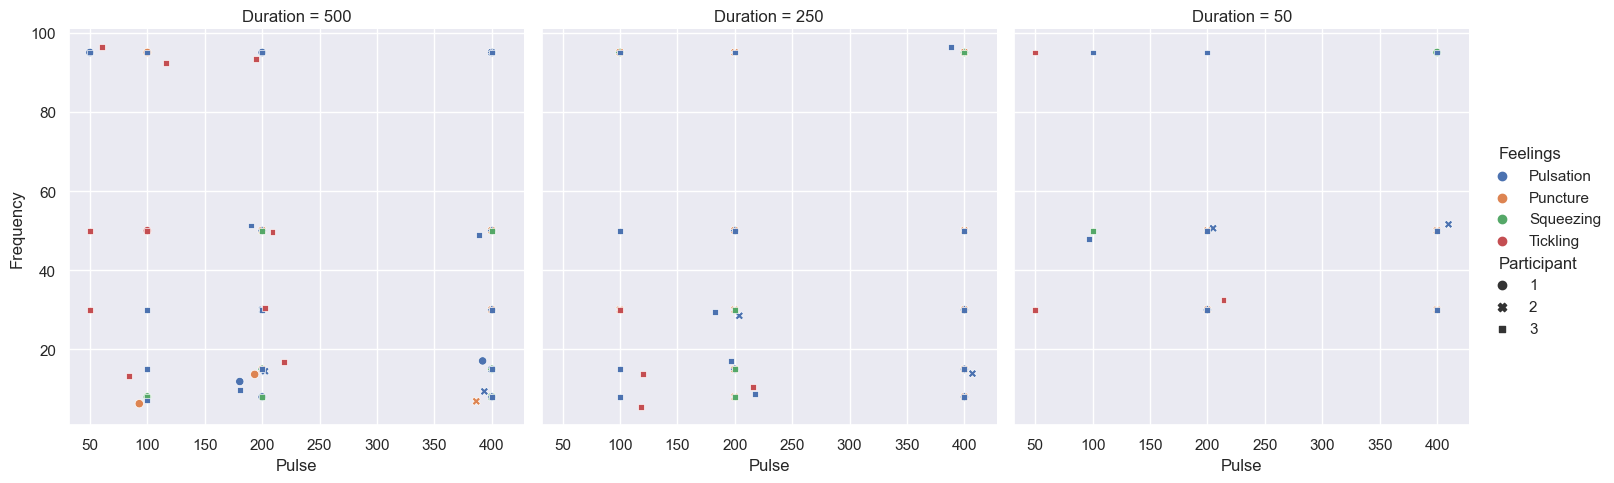

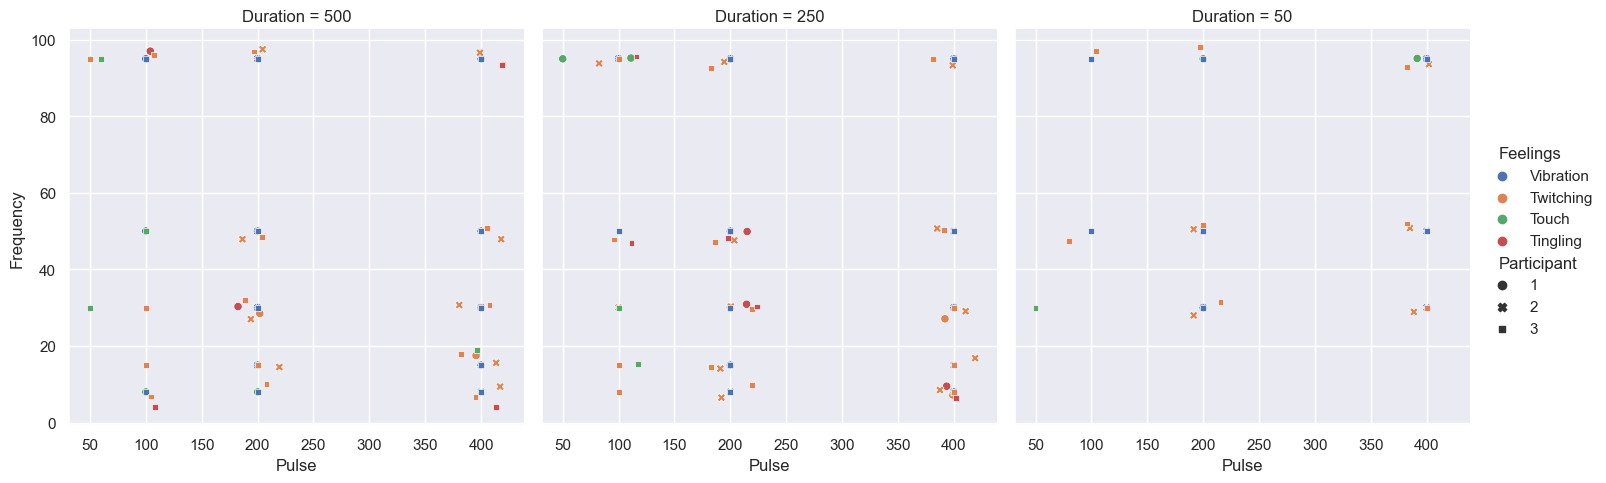

In [45]:
for data in range(4):
    sns.set_theme()
    sns.relplot(
        data=Data_dict[str(data+1)],
        x="Pulse", y="Frequency", col="Duration",
        hue="Feelings", style="Participant"
    )
    plt.show()
    #plt.savefig(exp + f'\Plots\Feelings_{data}.png')
    #plt.close()

Графики для зон ощущений

In [47]:
Data_felt

,Participant,Pulse,Frequency,Duration,Picture,Familiarity of Stimulation,Painfulness,Phantom Pain Intensity,Feeling of Movement,Temperature Changes,...,PredR 9,PredR 10,PredR 11,PredR 12,PredR 13,PredR 14,PredR 15,PredR 16,PredR 17,PicList
1,Knyshenko,200,50,500,1,-1.4,0.0,0.0,8.4,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1 5 6 9 10 11 16
4,Knyshenko,200,15,250,4,-2.1,0.0,0.0,6.5,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5 6 10 11 16
5,Knyshenko,400,95,500,5,-2.8,2.6,0.0,1.2,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1 5 6 9 10 11 12 13 16
6,Knyshenko,400,30,250,6,-3.1,0.9,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1 3 5 6 9 10 11 12 13 16
11,Knyshenko,200,95,50,11,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,5 6 9 10 11 12 13 16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,Suin,400,50,500,47,-5.0,0.0,0.0,2.9,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1 3 4 5 6 7 8 9 10 11 12 13 14 16 17
307,Suin,100,50,50,48,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,9 16 17
308,Suin,400,30,250,49,-5.0,0.0,0.0,2.3,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,5 6 7 10 11 12 13 14
309,Suin,100,15,500,50,-0.9,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,16 17


In [48]:

to_x = ['Electric Current', 'Hit', 'Intention to Make Movement',
        'Itching', 'Muscle contraction', 'Numbness', 'Prickling',
        'Pulsation', 'Puncture', 'Squeezing', 'Tickling',
        'Tingling', 'Touch', 'Twitching', 'Vibration', 'PicList', 'Was Felt',
        'Picture', 'Familiarity of Stimulation', 'Painfulness','Phantom Pain Intensity',
        'Feeling of Movement', 'Temperature Changes', 'Tactile Intensity']

Data_felt_for_Feel_Pics = Data_felt.drop(columns=to_x)
Data_felt_for_Feel_Pics.to_csv('Temp.csv', index=False)

In [69]:
import random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

Data_felt_for_Feel_Pics = pd.read_csv('Temp.csv')

drop2 = [['PredR 1','PredR 2','PredR 3','PredR 4','PredR 5','PredR 6','PredR 7', 'PredR 8','PredR 9','PredR 10','PredR 11'],
         ['PredR 7','PredR 8','PredR 9','PredR 10','PredR 11','PredR 12', 'PredR 13','PredR 14','PredR 15','PredR 16', 'PredR 17'], 
         ['PredR 1','PredR 2','PredR 3','PredR 4','PredR 5','PredR 6', 'PredR 12', 'PredR 13','PredR 14','PredR 15','PredR 16', 'PredR 17']]

#Data_dict = {'1': '','2': '','3': ''}
Data_dict = {'1': '','2': '','3': ''}
for w in range(len(drop2)):
    # for ww in range(len(drop2)):
    #     drop2[w][ww] = 'PredR ' + drop2[w][ww]
    Data_dict[str(w+1)] = Data_felt_for_Feel_Pics.drop(columns=drop2[w])
    np_f = Data_dict[str(w+1)].to_numpy()
    key_list = list(Data_dict[str(w+1)].keys())


    full_feel = []
    full_t = np_f.tolist()
    for j in range(np_f.shape[0]):
        temp = []
        temp_temp = []
        temp_feel = []
        for i in range(np_f.shape[1]):
            if i < 4:
                temp.append(full_t[j][i])
                temp_temp.append(full_t[j][i])
            if i >=4:
                if full_t[j][i] == 1.0:
                    temp_feel.append(key_list[i].split(' ')[1])
                if i == np_f.shape[1]-1:
                    full_feel.append(temp_feel)
    
    full = []
    for j in range(np_f.shape[0]):
        temp = []
        temp_temp = []
        temp_feel = []
        for i in range(4):
            if i < 4:
                temp.append(full_t[j][i])
        
        for name in full_feel[j]:
            temp.append(name)
            full.append(temp)
            temp = temp[:-1]
            for s in range(len(temp)):
                # if s > 0 and s < 3:
                #     temp[s] = float(temp[s] + random.randint(-20,20)/10)
                if s == 1:
                    temp[s] = float(temp[s] + random.randint(-40,40)/2)
                if s == 2:
                    temp[s] = float(temp[s] + random.randint(-30,30)/10)
                0

    full = np.array(full)
    Data_dict[str(w+1)] = pd.DataFrame(full, columns=['Participant', 'Pulse', 'Frequency', 'Duration', 'Regions'])
    Data_dict[str(w+1)] = Data_dict[str(w+1)].astype({'Frequency': float, 'Pulse': float})

In [50]:
import os 
exp = os.getcwd() + '\Data prepared\Plots'
exp

'c:\\Users\\asus\\0_LAB\\Neurotech\\Project\\TENSense\\Analysis\\Data prepared\\Plots'

In [70]:
for i in range(3):
    display(Data_dict[str(i+1)].groupby('Regions').count())
    #display(Data_dict[str(i+1)])

,Participant,Pulse,Frequency,Duration
Regions,,,,
12,43,43,43,43
13,58,58,58,58
14,34,34,34,34
16,54,54,54,54
17,65,65,65,65


,Participant,Pulse,Frequency,Duration
Regions,,,,
1,9,9,9,9
2,2,2,2,2
3,25,25,25,25
4,33,33,33,33
5,75,75,75,75
6,63,63,63,63


,Participant,Pulse,Frequency,Duration
Regions,,,,
10,34,34,34,34
11,37,37,37,37
7,35,35,35,35
8,18,18,18,18
9,21,21,21,21


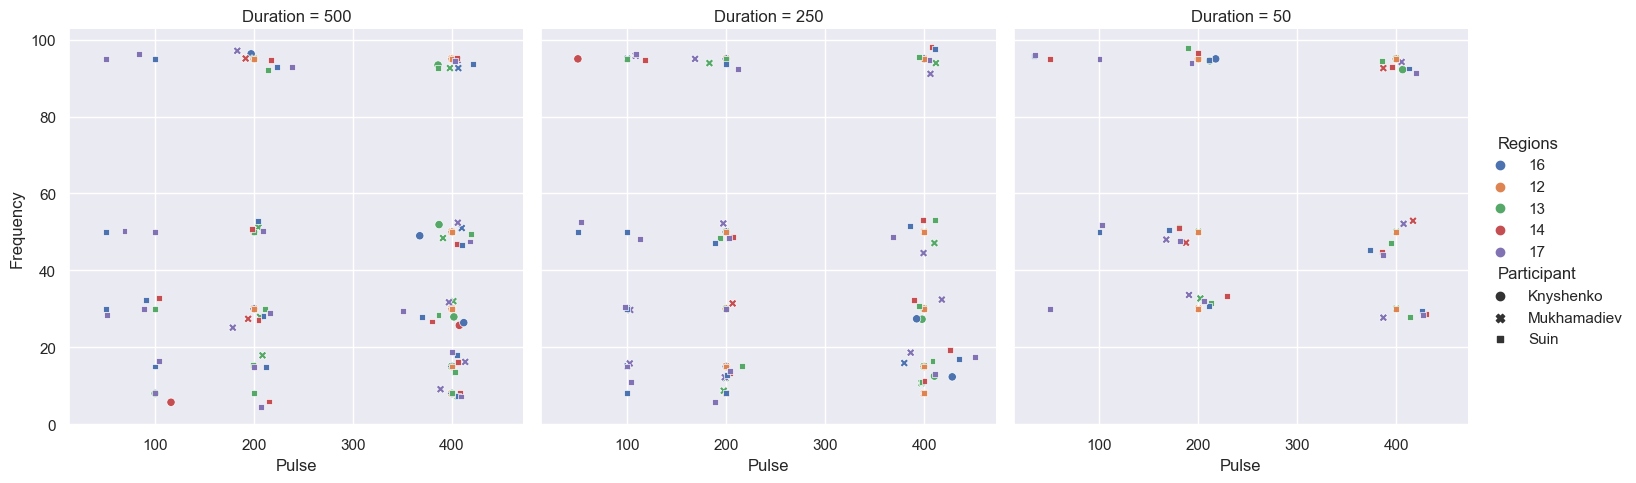

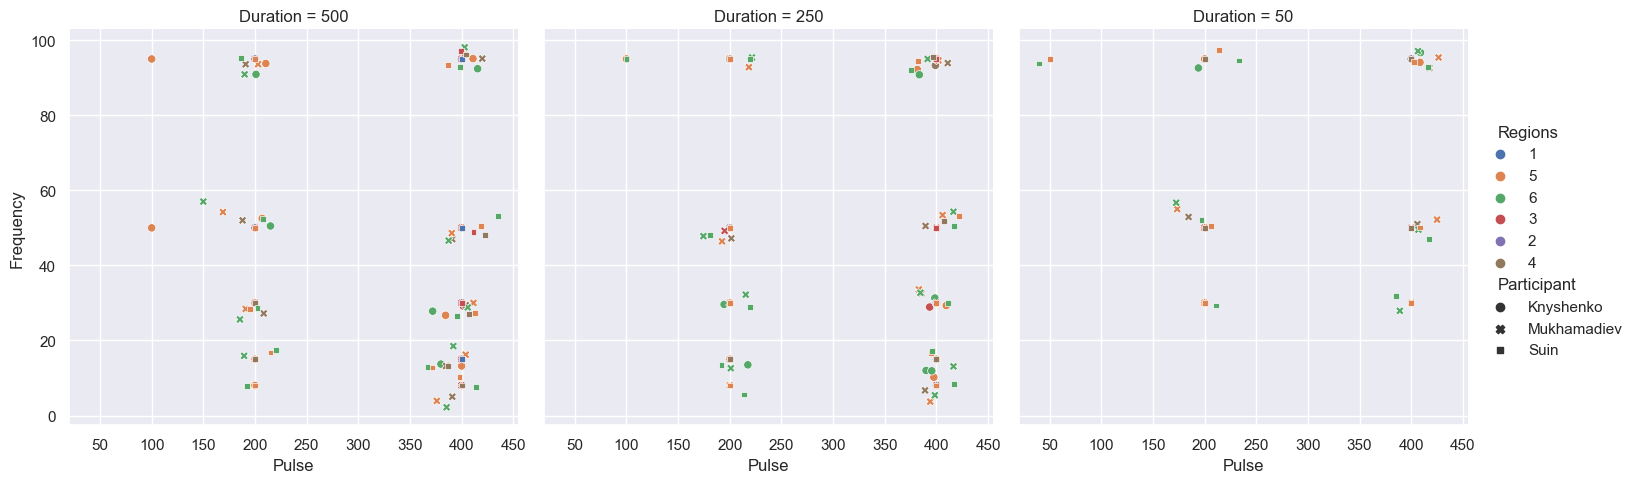

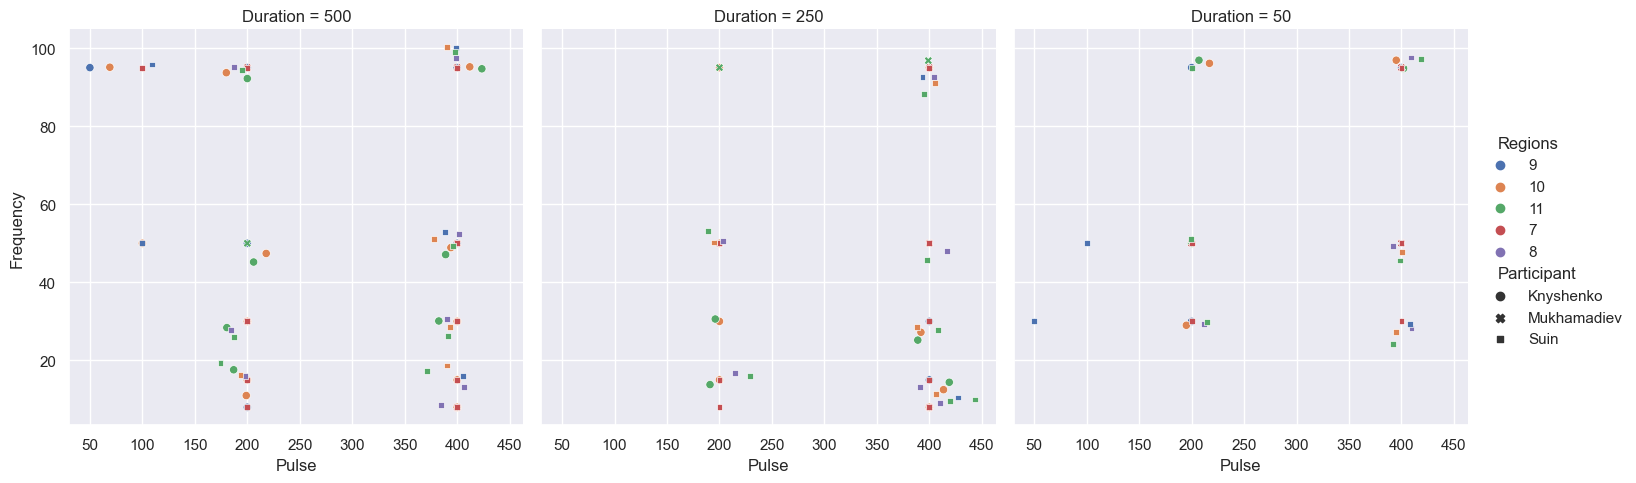

In [71]:
for data in range(3):
    
    sns.set_theme()
    sns.relplot(
        data=Data_dict[str(data+1)],
        x="Pulse", y="Frequency", col="Duration",
        hue="Regions", style="Participant", 
    )
    plt.show()
    # plt.savefig(exp + f'\Regions_{data}.png')
    # plt.close()

In [77]:
import random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

Data_felt_for_Feel_Pics = pd.read_csv('Temp.csv')

drop2 = [['PredR 1','PredR 2','PredR 3','PredR 4','PredR 5','PredR 6','PredR 7', 'PredR 8','PredR 9','PredR 10','PredR 11'],
         ['PredR 7','PredR 8','PredR 9','PredR 10','PredR 11','PredR 12', 'PredR 13','PredR 14','PredR 15','PredR 16', 'PredR 17'], 
         ['PredR 1','PredR 2','PredR 3','PredR 4','PredR 5','PredR 6', 'PredR 12', 'PredR 13','PredR 14','PredR 15','PredR 16', 'PredR 17']]

#Data_dict = {'1': '','2': '','3': ''}
Data_dict = {'1': '','2': '','3': ''}
for w in range(len(drop2)):
    # for ww in range(len(drop2)):
    #     drop2[w][ww] = 'PredR ' + drop2[w][ww]
    Data_dict[str(w+1)] = Data_felt_for_Feel_Pics.drop(columns=drop2[w])
    np_f = Data_dict[str(w+1)].to_numpy()
    key_list = list(Data_dict[str(w+1)].keys())


    full_feel = []
    full_t = np_f.tolist()
    for j in range(np_f.shape[0]):
        temp = []
        temp_temp = []
        temp_feel = []
        for i in range(np_f.shape[1]):
            if i < 4:
                temp.append(full_t[j][i])
                temp_temp.append(full_t[j][i])
            if i >=4:
                if full_t[j][i] == 1.0:
                    temp_feel.append(key_list[i].split(' ')[1])
                if i == np_f.shape[1]-1:
                    full_feel.append(temp_feel)
    
    full = []
    for j in range(np_f.shape[0]):
        temp = []
        temp_temp = []
        temp_feel = []
        for i in range(4):
            if i < 4:
                temp.append(full_t[j][i])
        
        for name in full_feel[j]:
            temp.append(name)
            full.append(temp)
            temp = temp[:-1]
            for s in range(len(temp)):
                # if s > 0 and s < 3:
                #     temp[s] = float(temp[s] + random.randint(-20,20)/10)
                if s == 1:
                    temp[s] = float(temp[s] + random.randint(-40,40)/2)
                if s == 2:
                    temp[s] = float(temp[s] + random.randint(-30,30)/10)
                if s == 3:
                    temp[s] = float(temp[s] + random.randint(-60,60)/2)
                

    full = np.array(full)
    Data_dict[str(w+1)] = pd.DataFrame(full, columns=['Participant', 'Pulse', 'Frequency', 'Duration', 'Regions'])
    Data_dict[str(w+1)] = Data_dict[str(w+1)].astype({'Frequency': float, 'Pulse': float})

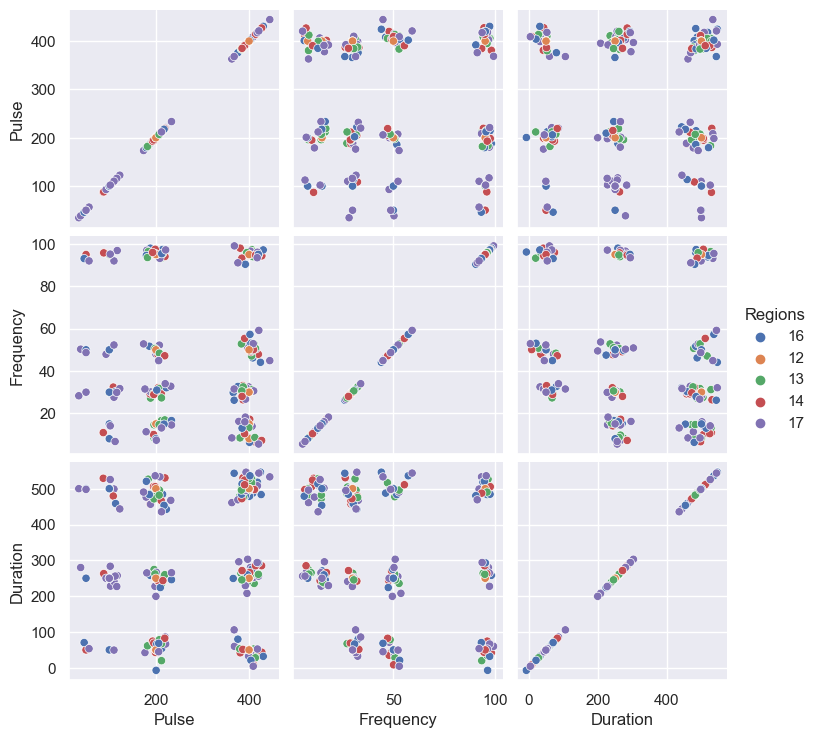

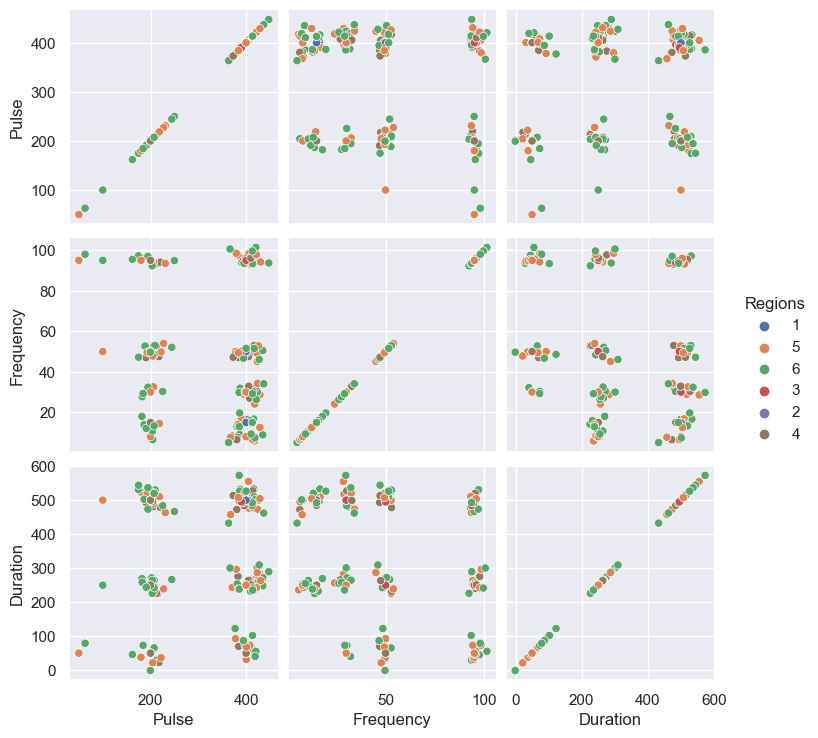

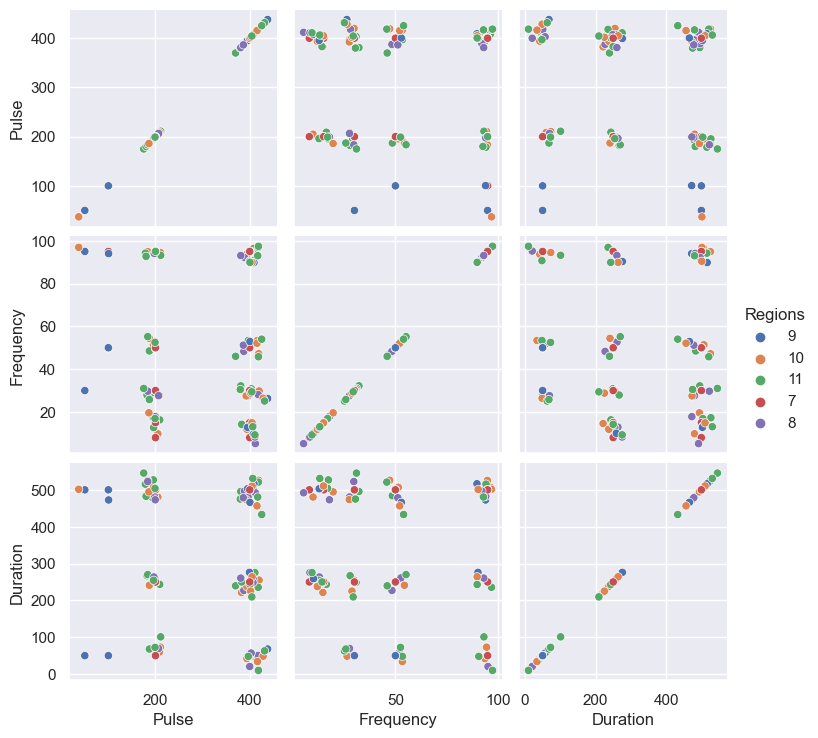

In [78]:

for data in range(3):
    
    Data_dict[str(data+1)] = Data_dict[str(data+1)].astype({'Duration': float})
    sns.set_theme()
    sns.pairplot(data=Data_dict[str(data+1)], hue="Regions", diag_kind=None)
    plt.show()
    # plt.savefig(exp + f'\Regions_hists_{data}.png')
    # plt.close()

In [65]:
Data_dict[str(w+1)].iloc[1][3]

500.0